# Milestone 3

Firstly, we import all the packages needed later.

In [2]:
import pandas as pd
import numpy as np
import os
import re
import string
import pickle
from datetime import datetime, date, time
from dateutil.parser import parse

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly
import plotly.graph_objs as go

import geopandas as gpd
import nltk
from fiona.crs import from_epsg,from_string
from geopy.extra.rate_limiter import RateLimiter
from geopandas.tools import geocode
from geopy.geocoders import Nominatim

from statsmodels.graphics.mosaicplot import mosaic
from geopy.exc import GeocoderTimedOut
from matplotlib.colors import ListedColormap
from matplotlib.path import Path
from folium.plugins import MarkerCluster

from pandas.plotting import scatter_matrix
from scipy import stats

from itertools import chain
from itertools import combinations

from collections import Counter

from shapely.geometry import Polygon, Point, MultiPolygon

In [11]:
import folium
import descartes
import shapely,geopandas,fiona 
import nltk

In [87]:
import sklearn
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

In [12]:
# from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.model_selection import cross_val_predict
# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import mean_squared_error
# from sklearn import linear_model, datasets
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier

## 1. Data Preprocessing

We first do some basic handlings for the whole dataset. 

* Discard last five columns which full of none value 

* Discard `Location` which contains the repated information with `Latitude` and `Longitude` columns

* Drop the rows duplicated with the previous one consider on all the columns except "Inspection ID" and "AkA name"

* standarize data format of some columns

In [14]:
# import raw dataset
data = pd.read_csv('Data/food-inspections.csv', sep = ',')
DF = data.copy()

# drop duplicate rows
DF = DF.drop_duplicates(subset = ['DBA Name','AKA Name', 'License #', 'Facility Type',
                                   'Risk', 'Address', 'City', 'State', 'Zip', 'Inspection Date',
                                   'Inspection Type', 'Results', 'Violations', 'Latitude', 'Longitude',
                                   'Location', 'Historical Wards 2003-2015', 'Zip Codes',
                                   'Community Areas', 'Census Tracts', 'Wards'], keep = 'first')
# drop all NaN columns
DF = DF.drop(columns = ['Location', 'Community Areas', 'Census Tracts', 'Wards', 'Historical Wards 2003-2015', 'Zip Codes'])

# standarize data format
DF['License #'] = DF['License #'].astype('Int32')
DF['Zip'] = DF['Zip'].astype('Int32')

# parse date
DF['Inspection Date'] = DF['Inspection Date'].apply(lambda d: parse(d))

DF.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
0,2345318,SUBWAY,SUBWAY,2529116,Restaurant,Risk 1 (High),2620 N NARRAGANSETT AVE,CHICAGO,IL,60639,2019-11-08,Canvass Re-Inspection,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.927995,-87.785752
1,2345321,GOPUFF,GOPUFF,2684560,Grocery Store,Risk 3 (Low),1801 W WARNER AVE,CHICAGO,IL,60613,2019-11-08,License Re-Inspection,Pass,NaN,41.956846,-87.674395
2,2345334,LA MICHOACANA ICE CREAM SHOP,LA MICHOACANA ICE CREAM SHOP,2698396,Restaurant,Risk 1 (High),3591-3597 N MILWAUKEE AVE,CHICAGO,IL,60641,2019-11-08,License,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.946140,-87.735183
3,2345339,THE CREPE SHOP,THE CREPE SHOP,2699005,Restaurant,Risk 1 (High),2934 N BROADWAY,CHICAGO,IL,60657,2019-11-08,License,Fail,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,41.935930,-87.644407
4,2345319,GOPUFF,GOPUFF,2684558,Grocery Store,Risk 3 (Low),1801 W WARNER AVE,CHICAGO,IL,60613,2019-11-08,License Re-Inspection,Pass,39. CONTAMINATION PREVENTED DURING FOOD PREPAR...,41.956846,-87.674395


Then, we will do cleaning for each column.

#### DBA Name

There is no missing value in `DBA Name` columns which is good. Then, we do casefolding for them.

In [15]:
DF['DBA Name'].isnull().sum()

0

In [16]:
print('There are', len(DF['DBA Name'].unique()), ' unique "DBA Name" before casefolding.')
print('There are', len(DF['DBA Name'].str.lower().unique()), ' unique "DBA Name" after casefolding.')
DF['DBA Name'] = DF['DBA Name'].str.lower()

There are 27545  unique "DBA Name" before casefolding.
There are 27259  unique "DBA Name" after casefolding.


#### License \#

Considering license number as ID of food establishment, we drop those with missing value in `License #` column.

In [17]:
print('There are', DF['License #'].isnull().sum(), 'mising entries in "License #"')
DF = DF[~DF['License #'].isnull()]

There are 17 mising entries in "License #"


Now, we consider if the inspection frequency of license number is reasonable. We can see that few establishments have been inspected for several times. 

Checking those strange license, we can see:

* For `License #` = 0.0, the facility type and address of entries are total different which implies inspectors may put establishments unknown into this license number.

* Checking the followed 4 license number, the `Inspections Date` and `DBA Name` give us some clues. Combining the high inspection frequency (these establishments can be checked several times within one day) and uniform facility type (they are all large-scale gymnasiums), we can consider that several food establishments in a gym are placed under one `License #`.

Therefore, we just drop those data. Besides, for the second situation, we drop rows by address.

In [18]:
license_freq = DF.groupby(['License #']).size().sort_values(ascending = False)
license_freq[license_freq > 40] 

License #
0          508
1354323    177
14616      176
1574001     83
1974745     59
1142451     49
1884255     48
2083833     46
1490035     46
1596210     45
60184       44
20481       44
1476553     42
1000572     41
dtype: int64

In [19]:
DF[DF['License #'] == 0].head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
1074,2315561,dore early childhood center,DORE EARLY CHILDHOOD CENTER,0,School,Risk 1 (High),6108 S Natoma AVE,CHICAGO,IL,60638,2019-10-09,Canvass,Pass,NaN,41.780927,-87.787640
1362,2313166,el costeno,EL COSTENO,0,Mobile Food Preparer,Risk 1 (High),235 W 87TH ST,CHICAGO,IL,60620,2019-10-01,Complaint,Fail,"1. PERSON IN CHARGE PRESENT, DEMONSTRATES KNOW...",41.735933,-87.629878
1500,2313036,taft freshman academy,TAFT FRESHMAN ACADEMY,0,School,Risk 1 (High),4071 N OAK PARK AVE BSMT,CHICAGO,IL,60634,2019-09-27,Canvass,Pass,52. SEWAGE & WASTE WATER PROPERLY DISPOSED - C...,41.954631,-87.796455
1939,2312477,body factory nutrition,BODY FACTORY NUTRITION,0,FITNESS CENTER,Risk 2 (Medium),1500 W 51ST ST,CHICAGO,IL,60609,2019-09-18,Complaint Re-Inspection,Out of Business,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,41.801459,-87.662410
2591,2311708,st. athanasios & john greek orthodox church,ST. ATHANASIOS & JOHN GREEK OROTHODOX CHURCH,0,CHURCH (SPECIAL EVENTS),Risk 1 (High),4200 N KEELER AVE,CHICAGO,IL,60641,2019-09-04,Canvass,Pass w/ Conditions,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,41.957334,-87.732733


In [20]:
DF[DF['License #'] == 1354323].head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
121289,1375470,sportservice soldier field,GRILL & BAR,1354323,Restaurant,Risk 2 (Medium),1410 S MUSEUM CAMPUS DR,CHICAGO,IL,60605,2013-11-15,Canvass,Out of Business,NaN,41.862628,-87.615031
121310,1375472,sportservice soldier field,PIZZA STAND,1354323,Restaurant,Risk 2 (Medium),1410 S MUSEUM CAMPUS DR,CHICAGO,IL,60605,2013-11-15,Canvass,Out of Business,NaN,41.862628,-87.615031
121311,1375475,sportservice soldier field,CHICAGO DOGS,1354323,Restaurant,Risk 2 (Medium),1410 S MUSEUM CAMPUS DR,CHICAGO,IL,60605,2013-11-15,Canvass,Out of Business,NaN,41.862628,-87.615031
121337,1375473,sportservice soldier field,HOT DOG AND BAR,1354323,Restaurant,Risk 2 (Medium),1410 S MUSEUM CAMPUS DR,CHICAGO,IL,60605,2013-11-15,Canvass,Out of Business,NaN,41.862628,-87.615031
121382,1375471,sportservice soldier field,BBQ STAND,1354323,Restaurant,Risk 2 (Medium),1410 S MUSEUM CAMPUS DR,CHICAGO,IL,60605,2013-11-15,Canvass,Out of Business,NaN,41.862628,-87.615031


In [21]:
DF[DF['License #'] == 14616].head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
8131,2288971,"illinois sportservice, inc.",GUARANTEED RATE FIELD,14616,STADIUM,Risk 2 (Medium),333 W 35TH ST,CHICAGO,IL,60616,2019-05-16,Canvass Re-Inspection,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.830784,-87.635296
8225,2288859,"illinois sportservice, inc.",GUARANTEED RATE FIELD,14616,STADIUM,Risk 2 (Medium),333 W 35TH ST,CHICAGO,IL,60616,2019-05-14,Canvass,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.830784,-87.635296
23475,2181546,"illinois sportservice, inc.",GUARANTEED RATE FIELD,14616,STADIUM,Risk 2 (Medium),333 W 35TH ST,CHICAGO,IL,60616,2018-06-18,Canvass Re-Inspection,Pass,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.830784,-87.635296
23658,2181490,"illinois sportservice, inc.",GUARANTEED RATE FIELD,14616,STADIUM,Risk 2 (Medium),333 W 35TH ST,CHICAGO,IL,60616,2018-06-14,Canvass,Fail,2. FACILITIES TO MAINTAIN PROPER TEMPERATURE -...,41.830784,-87.635296
43365,2064598,"illinois sportservice, inc.",GUARANTEED RATE FIELD,14616,STADIUM,Risk 2 (Medium),333 W 35TH ST,CHICAGO,IL,60616,2017-06-20,Canvass Re-Inspection,Pass,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.830784,-87.635296


In [22]:
DF[DF['License #'] == 1574001].head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
4850,2303355,levy restaurants @ wrigley field,WRIGLEY FIELD STADIUM,1574001,STADIUM,Risk 1 (High),1060 W ADDISON ST,CHICAGO,IL,60613,2019-07-17,Canvass,Pass w/ Conditions,8. HANDS CLEAN & PROPERLY WASHED - Comments: O...,41.947317,-87.656418
23903,2177124,levy restaurants @ wrigley field,WRIGLEY FIELD STADIUM,1574001,STADIUM,Risk 1 (High),1060 W ADDISON ST,CHICAGO,IL,60613,2018-06-11,Canvass Re-Inspection,Pass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",41.947317,-87.656418
24091,2177010,levy restaurants @ wrigley field,WRIGLEY FIELD STADIUM,1574001,STADIUM,Risk 1 (High),1060 W ADDISON ST,CHICAGO,IL,60613,2018-06-07,Canvass,Pass w/ Conditions,2. FACILITIES TO MAINTAIN PROPER TEMPERATURE -...,41.947317,-87.656418
40428,2078233,levy restaurants at wrigley field,TRIPPER'S #1001,1574001,Restaurant,Risk 2 (Medium),1060 W ADDISON ST,CHICAGO,IL,60613,2017-08-10,Canvass,Out of Business,NaN,41.947317,-87.656418
43250,2064698,levy restaurants @ wrigley field,WRIGLEY FIELD STADIUM,1574001,STADIUM,Risk 1 (High),1060 W ADDISON ST,CHICAGO,IL,60613,2017-06-21,Complaint,Pass w/ Conditions,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.947317,-87.656418


In [23]:
DF[DF['License #'] == 1974745].head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
34940,2104261,levy restaurants at united center,UNITED CENTER,1974745,Restaurant,Risk 1 (High),1901 W MADISON ST,CHICAGO,IL,60612,2017-11-07,Canvass,Out of Business,NaN,41.881241,-87.674283
58273,1966659,levy restaurants at united center,UNITED CENTER,1974745,Restaurant,Risk 1 (High),1901 W MADISON ST,CHICAGO,IL,60612,2016-10-17,Canvass,Pass,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.881241,-87.674283
81031,1583214,levy restaurants at united center,UNITED CENTER,1974745,Restaurant,Risk 1 (High),1901 W MADISON ST,CHICAGO,IL,60612,2015-10-20,Canvass,Pass w/ Conditions,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.881241,-87.674283
97173,1515783,levy restaurants at united center,UNITED CENTER,1974745,Restaurant,Risk 1 (High),1901 W MADISON ST,CHICAGO,IL,60612,2015-01-12,Short Form Complaint,Pass,NaN,41.881241,-87.674283
102652,1480333,levy restaurants at united center,UNITED CENTER,1974745,Restaurant,Risk 1 (High),1901 W MADISON ST,CHICAGO,IL,60612,2014-10-08,Canvass Re-Inspection,Pass,31. CLEAN MULTI-USE UTENSILS AND SINGLE SERVIC...,41.881241,-87.674283


In [31]:
print('For each gym, we drop', DF[DF['Address'] == '1410 S MUSEUM CAMPUS DR '].shape[0], ',', \
                               DF[DF['Address'] == '333 W 35TH ST '].shape[0], ',', \
                               DF[DF['Address'] == '1060 W ADDISON ST '].shape[0], ',', \
                               DF[DF['Address'] == '1901 W MADISON ST '].shape[0], 'rows.')
DF = DF[~((DF['Address'] == '1410 S MUSEUM CAMPUS DR ') | \
          (DF['Address'] == '333 W 35TH ST ') | \
          (DF['Address'] == '1060 W ADDISON ST ') | \
          (DF['Address'] == '1901 W MADISON ST '))]

For each gym, we drop 0 , 0 , 0 , 0 rows.


#### Facility Type

We checked type of facility which has a lot. 

But some categories only contain few restaurants, so we consider group those with few restaurants (less than 100) together as a `others` group. 

Moreover, according to the description file, we generalized some categories. For instance, we grouped `mobile food preparer`, `mobile food dispenser`, and `mobile prepared food vendor` into `moblie food dispenser`.

In [25]:
DF["Facility Type"] = DF["Facility Type"].str.lower()
DF["Facility Type"] = DF["Facility Type"].fillna('unknown')

print('There are', len(DF["Facility Type"].unique()), 'types of facility.')

facility_type = DF["Facility Type"].value_counts()
facility_type[0:30]

There are 438 types of facility.


restaurant                         129717
grocery store                       24898
school                              12104
unknown                              4764
children's services facility         3070
bakery                               2864
daycare (2 - 6 years)                2687
daycare above and under 2 years      2366
long term care                       1346
catering                             1185
mobile food dispenser                 869
liquor                                845
daycare combo 1586                    751
mobile food preparer                  631
golden diner                          566
hospital                              548
wholesale                             534
tavern                                319
daycare (under 2 years)               249
special event                         208
shared kitchen user (long term)       199
banquet hall                          167
gas station                           140
mobile prepared food vendor       

In [26]:
fac_greater100 = facility_type[facility_type.values >= 100]

# generalize some categories
fac_type_correction = {}
for i in range(len(facility_type)):
    match = facility_type.index[i]
    if re.match(r'(.*?school.*?)', match) != None:
        fac_type_correction[match] = 'school'
    elif re.match(r'(.*?mobile.*?)', match) != None:
        fac_type_correction[match] = 'moblie food dispenser'
    elif re.match(r'.*?(kiosk).*?', match) != None:
        fac_type_correction[match] = 'kiosk'
    elif re.match(r'.*?daycare (.*?2 years).*?', match) != None:
        fac_type_correction[match] = 'daycare(0 - 2 years)'
    elif re.match(r'.*?shared kitchen.*?', match) != None:
        fac_type_correction[match] = 'shared kitchen'
    elif match in fac_greater100:
        fac_type_correction[match] = match
    elif match == 'unknown':
        fac_type_correction[match] = 'unknown'
    else:
        fac_type_correction[match] = 'others'        
DF['facility type'] = DF['Facility Type'].map(fac_type_correction)

# renew facilitye type
facility_type = DF['facility type'].value_counts()

print('There are', len(DF['facility type'].value_counts()), 'type of facility.')

There are 23 type of facility.


#### Risk

Accoding to the procedure of risk setting:

_During the inspection, the health inspector will assess the types of food that will be prepared and the methods used for preparing and serving the food. This information will be used to assign a ‘risk-level’ – risk 1, 2 or 3 – to the food establishment.  This risk level will be used to determine how frequent a food establishment needs to be inspected._

_——Chicago,gov._

we can see that risk level only has something to do with type and storage methods of food, so one food establishment cannot be categoried as `All` risk level. Besides, results of these inspections are mainly `Not Ready` which also indicates that it is a temporary value for having no result.

Therefore, we drop those entries.

In [27]:
DF.groupby('Risk').size()

Risk
All                    29
Risk 1 (High)      139939
Risk 2 (Medium)     37616
Risk 3 (Low)        17036
dtype: int64

In [28]:
DF[DF['Risk'] == 'All'].head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,facility type
409,2320498,chicago's home of chicken & waffles,CHICAGO'S HOME OF CHICKEN & WAFFLES,2698292,unknown,All,3947 S DR MARTIN LUTHER KING JR DR,CHICAGO,IL,60653,2019-10-25,License,Not Ready,NaN,41.822548,-87.616816,unknown
1036,2315596,two hearted queen,TWO HEARTED QUEEN,2694759,restaurant,All,3500 N HALSTED ST,CHICAGO,IL,60657,2019-10-09,License,Not Ready,NaN,41.945504,-87.649579,restaurant
1256,2315299,kilwins ice cream and chocolate,KILWINS ICE CREAM AND CHOCOLATE,2694404,unknown,All,3519 N CLARK ST,CHICAGO,IL,60657,2019-10-03,License,Not Ready,NaN,41.946281,-87.655603,unknown
1778,2312632,supermercado el paraiso inc.,SUPERMERCADO EL PARAISO INC.,2670414,grocery store,All,4301 S ARCHER AVE,CHICAGO,IL,60632,2019-09-20,Canvass,Out of Business,NaN,41.815301,-87.702042,grocery store
2074,2312348,khepri cafe,KHEPRI CAFE,2683983,unknown,All,4650 N KEDZIE AVE,CHICAGO,IL,60625,2019-09-16,License,Not Ready,NaN,41.966062,-87.708548,unknown


In [29]:
DF = DF[~DF['Risk'].isin(['All'])]

#### Latitude and Longitude

For latitude and longitude, we use geocode to fill in the missing values.

In [30]:
locator = Nominatim(user_agent="my-application")
geocode = RateLimiter(locator.geocode)
copy = DF.copy()
copy = copy[copy['Latitude'].isna()]
for i in range(len(copy)):
    try:
        copy.iloc[i,-2]=locator.geocode(copy.iloc[i,-10]+copy.iloc[i,-9]).latitude
        copy.iloc[i,-1]=locator.geocode(copy.iloc[i,-10]+copy.iloc[i,-9]).longitude
    except:
        pass

print('number of filled values : {}'.format(len(DF[DF['Latitude'].isna()])-len(copy[copy['Latitude'].isna()])))
print('number of NaN values remaining: {}'.format(len(DF[DF['Latitude'].isna()])-len(copy[~copy['Latitude'].isna()])))

DF[DF['Latitude'].isna()] = copy

number of filled values : 0
number of NaN values remaining: 686


#### Inspection Date

In [32]:
DF['year'] = DF['Inspection Date'].apply(lambda x :x.year)
DF['month'] = DF['Inspection Date'].apply(lambda x :x.month)
DF['day'] = DF['Inspection Date'].apply(lambda x :x.day)

#### Inspection Type

The mainly inspection type are `canvass`, `license`, `complaint`, `consultation`, `food poisoning`, `task force`, and their corresonding re-inspections according to the description file. We can see that except those inspection types, the rests have few amounts. Therefore, we convert them into `others` inspection type.

In [33]:
DF['Inspection Type'] = DF['Inspection Type'].str.lower()

ins_type = DF.groupby('Inspection Type').size().sort_values(ascending = False)
ins_type

Inspection Type
canvass                                     102585
license                                      25815
canvass re-inspection                        20522
complaint                                    18116
license re-inspection                         8947
                                             ...  
license task force / not -for-profit clu         1
license task 1474                                1
license renewal inspection for daycare           1
license daycare 1586                             1
1315 license reinspection                        1
Length: 95, dtype: int64

In [34]:
# 12 main inspection type
inspection_type_stand = ['canvass', 'license', 'complaint', 'consultation', 'food poisoning', 'task force', \
                         'canvass re inspection', 'license re inspection', 'complaint re inspection', \
                         'consultation re inspection', 'food poisoning re inspection', 'task force re inspection', \
                         'others']
ins_type_others = []

# build inspection type correction dict
ins_type_correction = ins_type
for i in range(len(ins_type)):
    match = ins_type.index[i]
    if re.match(r'(.*?canvas.*?re.*?inspection.*?)', match) != None:
        ins_type_correction[match] = inspection_type_stand[6]
    elif re.match(r'(.*?canvas.*?)', match) != None:
        ins_type_correction[match] = inspection_type_stand[0]
    elif re.match(r'(.*?license.*?re.*?inspection.*?)', match) != None:
        ins_type_correction[match] = inspection_type_stand[7]
    elif re.match(r'(.*?license.*?)', match) != None:
        ins_type_correction[match] = inspection_type_stand[1]
    elif re.match(r'(.*?complain.*?re.*?inspection.*?)', match) != None:
        ins_type_correction[match] = inspection_type_stand[8]
    elif re.match(r'(.*?complain.*?)', match) != None:
        ins_type_correction[match] = inspection_type_stand[2]
    elif re.match(r'(.*?consultation.*?re.*?inspection.*?)', match) != None:
        ins_type_correction[match] = inspection_type_stand[9]
    elif re.match(r'(.*?consultation.*?)', match) != None:
        ins_type_correction[match] = inspection_type_stand[3]
    elif re.match(r'(.*?poisoning.*?re.*?inspection.*?)', match) != None:
        ins_type_correction[match] = inspection_type_stand[10]
    elif re.match(r'.*?(poisoning)|(sick).*?', match) != None:
        ins_type_correction[match] = inspection_type_stand[4]
    elif re.match(r'(.*?task.*?force.*?re.*?inspection.*?)', match) != None:
        ins_type_correction[match] = inspection_type_stand[11]
    elif re.match(r'.*?(task.*?force)|(liquor)|(tavern).*?', match) != None:
        ins_type_correction[match] = inspection_type_stand[5]
    else:
        ins_type_others.append(match)
        ins_type_correction[match] = inspection_type_stand[12]

# see the amounts of "others" inspection type
ins_others = DF[DF['Inspection Type'].apply(lambda x: x in ins_type_others)]
ins_others.groupby('Inspection Type').size().sort_values(ascending = False)

Inspection Type
tag removal                       593
recent inspection                 333
out of business                   305
no entry                           72
special events (festivals)         60
package liquor 1474                44
non-inspection                     14
not ready                          11
illegal operation                   5
sfp                                 4
reinspection                        2
reinspection of 48 hour notice      2
kids cafe                           1
corrective action                   1
duplicated                          1
citation re-issued                  1
error save                          1
expansion                           1
fire                                1
changed court date                  1
business not located                1
haccp questionaire                  1
citf                                1
two people ate and got sick.        1
kids cafe'                          1
kitchen closed for renovation     

In [35]:
# map inspection type correction dict
DF['inspection type'] = DF['Inspection Type'].map(ins_type_correction)
DF.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,...,Inspection Type,Results,Violations,Latitude,Longitude,facility type,year,month,day,inspection type
0,2345318,subway,SUBWAY,2529116,restaurant,Risk 1 (High),2620 N NARRAGANSETT AVE,CHICAGO,IL,60639,...,canvass re-inspection,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.927995,-87.785752,restaurant,2019,11,8,canvass re inspection
1,2345321,gopuff,GOPUFF,2684560,grocery store,Risk 3 (Low),1801 W WARNER AVE,CHICAGO,IL,60613,...,license re-inspection,Pass,NaN,41.956846,-87.674395,grocery store,2019,11,8,license re inspection
2,2345334,la michoacana ice cream shop,LA MICHOACANA ICE CREAM SHOP,2698396,restaurant,Risk 1 (High),3591-3597 N MILWAUKEE AVE,CHICAGO,IL,60641,...,license,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.946140,-87.735183,restaurant,2019,11,8,license
3,2345339,the crepe shop,THE CREPE SHOP,2699005,restaurant,Risk 1 (High),2934 N BROADWAY,CHICAGO,IL,60657,...,license,Fail,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,41.935930,-87.644407,restaurant,2019,11,8,license
4,2345319,gopuff,GOPUFF,2684558,grocery store,Risk 3 (Low),1801 W WARNER AVE,CHICAGO,IL,60613,...,license re-inspection,Pass,39. CONTAMINATION PREVENTED DURING FOOD PREPAR...,41.956846,-87.674395,grocery store,2019,11,8,license re inspection


#### Results

According to the description file, there are five types of results: `pass`, `pass with condition`, `fail`, `out of business`, and `not located` with increasing violation level. What's more, the last two types indicate that the establishment's license is suspended, so we grouped them together as `license suspended`.

It is obvious that `no entry` and `not ready` mean inspectors did not have access to the establishments at that time. So we grouped them into `No Access`.

In [36]:
DF.groupby('Results').size()

Results
Business Not Located        67
Fail                     37735
No Entry                  6203
Not Ready                 1856
Out of Business          16710
Pass                    105123
Pass w/ Conditions       26970
dtype: int64

In [37]:
# group "license suspended"
DF['results'] = DF['Results']
DF.loc[DF['results'] == 'Business Not Located', 'results'] = 'License Suspended'
DF.loc[DF['results'] == 'Out of Business', 'results'] = 'License Suspended'

# group "no access"
DF.loc[DF['results'] == 'No Entry', 'results'] = 'No Access'
DF.loc[DF['results'] == 'Not Ready', 'results'] = 'No Access'
DF_no_access = DF[DF['results'].isin(['No Entry', 'Not Ready'])]

DF.groupby('results').size()

results
Fail                   37735
License Suspended      16777
No Access               8059
Pass                  105123
Pass w/ Conditions     26970
dtype: int64

#### Violation

As violation number already implies enought information, we only keep the violation number here and discard their detailed comments.

In [38]:
def splite_violations(vio):
    vionum = []
    if pd.isna(vio) == False:
        vionum = [a.split("- Comments")[0] for a in str(vio).split('|')]
    return vionum


# extract the numbering of violations
df_vio = DF.copy()
df_vio['Violation_item'] = df_vio['Violations'].apply(lambda x :splite_violations(x))
df_vio['Violation_num'] = df_vio['Violation_item'].apply(lambda x:[int(a.split(".")[0]) for a in x])

The dataset also contains violation changes happened on 7/1/2018 which means definition or numbers of violation code would not be the same. Therefore, we seperate the dataset by that day.

In [39]:
df_vio1 = df_vio[df_vio["Inspection Date"] <= pd.datetime(2018,7,1)]
df_vio2 = df_vio[df_vio["Inspection Date"] > pd.datetime(2018,7,1)]

violation_item_1 = pd.Series(chain.from_iterable(list(df_vio1["Violation_item"]))).sort_values().unique()
violation_item_2 = pd.Series(chain.from_iterable(list(df_vio2["Violation_item"]))).sort_values().unique()

# extract all the 
df_vitem_2 = pd.DataFrame(violation_item_2,columns=['violations'])
df_vitem_2['code'] = df_vitem_2['violations'].apply(lambda x:int(x.split(".")[0]))
df_vitem_2['item'] = df_vitem_2['violations'].apply(lambda x:x.split(".")[1])
df_vitem_2 = df_vitem_2.groupby(['code']).head(1)
df_vitem_2 = df_vitem_2.set_index('code').sort_index()
df_vitem_2 = df_vitem_2.drop(columns = ['violations'])

df_vitem_1 = pd.DataFrame(violation_item_1,columns=['violations'])
df_vitem_1['code'] = df_vitem_1['violations'].apply(lambda x:int(x.split(".")[0]))
df_vitem_1['item'] = df_vitem_1['violations'].apply(lambda x:x.split(".")[1])
df_vitem_1 = df_vitem_1.groupby(['code']).head(1)
df_vitem_1 = df_vitem_1.set_index('code').sort_index()
df_vitem_1 = df_vitem_1.drop(columns = ['violations'])

df_vitem_1.head()

,item
code,
1,"SOURCE SOUND CONDITION, NO SPOILAGE, FOODS PR..."
2,FACILITIES TO MAINTAIN PROPER TEMPERATURE
3,POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATURE ...
4,SOURCE OF CROSS CONTAMINATION CONTROLLED I
5,PERSONNEL WITH INFECTIONS RESTRICTED: NO OPEN...


In [40]:
def expand_varible_1(vio):
    var = np.zeros(46)
    for i in vio:
        n = i-1
        if n == 69:
            n = 45
        var[n] = 1
    return var

def expand_varible_2(vio):
    var = np.zeros(63)
    for i in vio:
        n = i-1
        var[n] = 1
    return var

# get the over all violation list
violation_list_1 = pd.Series(chain.from_iterable(list(df_vio1["Violation_num"]))).sort_values().unique()
violation_list_2 = pd.Series(chain.from_iterable(list(df_vio2["Violation_num"]))).sort_values().unique()

df_vio1['Violation_vector'] = df_vio1['Violation_num'].apply(lambda x:expand_varible_1(x))
df_vio2['Violation_vector'] = df_vio2['Violation_num'].apply(lambda x:expand_varible_2(x))

for i in range(46):
    df_vio1['vio'+str(i+1)] = df_vio1['Violation_vector'].apply(lambda x:x[i])
    
for i in range(63):
    df_vio2['vio'+str(i+1)] = df_vio2['Violation_vector'].apply(lambda x:x[i])

D:\anaconda3\envs\ada\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

D:\anaconda3\envs\ada\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

D:\anaconda3\envs\ada\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

We finally finished our data cleaning! Then store them in pickle.

In [41]:
cleaned_whole_df = open('cleaned_whole_df.pkl', 'wb')
cleaned_df_vio1 = open('cleaned_df_vio1.pkl', 'wb')
cleaned_df_vio2 = open('cleaned_df_vio2.pkl', 'wb')
cleaned_df_vitem_1 = open('cleaned_df_vitem_1.pkl', 'wb')
cleaned_df_vitem_2 = open('cleaned_df_vitem_2.pkl', 'wb')
pickle.dump(DF, cleaned_whole_df)
pickle.dump(df_vio1, cleaned_df_vio1)
pickle.dump(df_vio2, cleaned_df_vio2)
pickle.dump(df_vitem_1, cleaned_df_vitem_1)
pickle.dump(df_vitem_2, cleaned_df_vitem_2)

## 2. Data Analysis and Visualization

In [42]:
# import the cleaned data
cleaned_whole_df = open('cleaned_whole_df.pkl', 'rb')
cleaned_df_vio1 = open('cleaned_df_vio1.pkl', 'rb')
cleaned_df_vio2 = open('cleaned_df_vio2.pkl', 'rb')
cleaned_df_vitem_1 = open('cleaned_df_vitem_1.pkl', 'rb')
cleaned_df_vitem_2 = open('cleaned_df_vitem_2.pkl', 'rb')
df_read = pickle.load(cleaned_whole_df)
df = df_read.drop(columns = ['AKA Name', 'Results', 'Inspection Type', 'Facility Type'])
df_vio1 = pickle.load(cleaned_df_vio1)
df_vio2 = pickle.load(cleaned_df_vio2)
df_vitem_1 = pickle.load(cleaned_df_vitem_1)
df_vitem_2 = pickle.load(cleaned_df_vitem_2)
df.head()

,Inspection ID,DBA Name,License #,Risk,Address,City,State,Zip,Inspection Date,Violations,Latitude,Longitude,facility type,year,month,day,inspection type,results
0,2345318,subway,2529116,Risk 1 (High),2620 N NARRAGANSETT AVE,CHICAGO,IL,60639,2019-11-08,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.927995,-87.785752,restaurant,2019,11,8,canvass re inspection,Pass w/ Conditions
1,2345321,gopuff,2684560,Risk 3 (Low),1801 W WARNER AVE,CHICAGO,IL,60613,2019-11-08,NaN,41.956846,-87.674395,grocery store,2019,11,8,license re inspection,Pass
2,2345334,la michoacana ice cream shop,2698396,Risk 1 (High),3591-3597 N MILWAUKEE AVE,CHICAGO,IL,60641,2019-11-08,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.946140,-87.735183,restaurant,2019,11,8,license,Pass w/ Conditions
3,2345339,the crepe shop,2699005,Risk 1 (High),2934 N BROADWAY,CHICAGO,IL,60657,2019-11-08,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,41.935930,-87.644407,restaurant,2019,11,8,license,Fail
4,2345319,gopuff,2684558,Risk 3 (Low),1801 W WARNER AVE,CHICAGO,IL,60613,2019-11-08,39. CONTAMINATION PREVENTED DURING FOOD PREPAR...,41.956846,-87.674395,grocery store,2019,11,8,license re inspection,Pass


### 2.1 Sanitary Conditions of Food Establishments

Here, we use the pass rate to represent sanitary conditions of food establishments. 

Pass rate is defined as numbers of `pass` and `pass with condition` over numbers of all results using results from all inspection types except `license` and `license re-inspection` since these kinds of inspection are announced, thus it's more like a pre inspection while others are unannounced.

#### 1) Changes over facility type

restaurant                      129709
grocery store                    24896
school                           12375
unknown                           4745
children's services facility      3070
Name: facility type, dtype: int64


<BarContainer object of 8 artists>

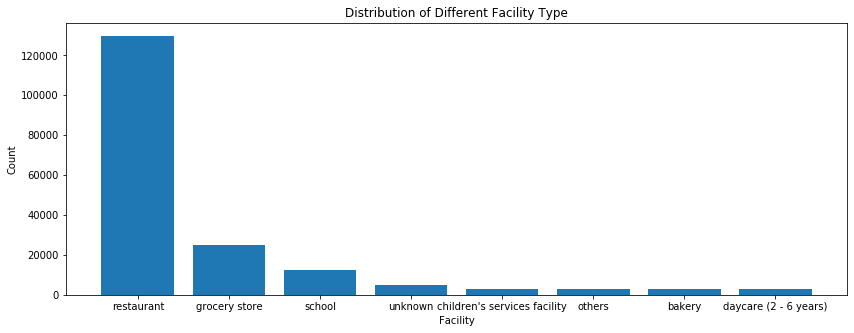

In [43]:
# numbers of inspections by facility
facility = df['facility type'].value_counts().index
fcounts = df['facility type'].value_counts()
print(fcounts.head())

fig = plt.figure(figsize=(14,5))
plt.xlabel('Facility')
plt.ylabel('Count')
plt.title('Distribution of Different Facility Type')
plt.bar(facility[0:8], fcounts.head(8))

In [48]:
# save in html
plotly.offline.plot({
    'data': [go.Bar(x = facility[0: 8], y = fcounts.head(8))],
    'layout': {'title': 'Distribution of Different Facility Type', \
               'font': dict(size = 16)}}, \
    auto_open = True, \
    filename = './HTML/Distribution of Different Facility Type', \
    validate = False)

The types are facilities are various, but there are only a few common types of facilities: Nearly 130,000 facilities are identified as 'Restaurant'. Grocery store and school are also common facilities. These three types of facilities account for over 90% of all facilities.

Text(0.5, 0, 'Facility Type')

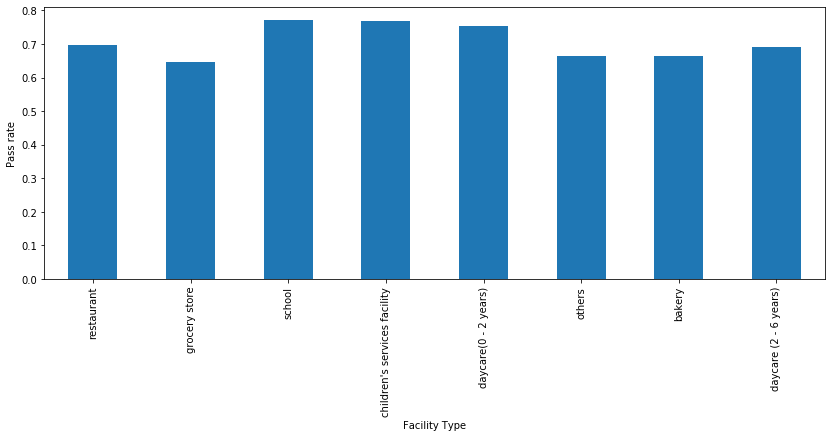

In [46]:
df['Pass'] = df['results']
df['Pass'] = df['Pass'].apply(lambda x:1 if x == 'Pass' \
                              else (1 if x == 'Pass w/ Conditions' else 0))

# passrate for facility types
DF_Ins_Pass = pd.DataFrame(df.groupby(['facility type'])['Pass'].sum()) 
DF_Ins_Pass = DF_Ins_Pass[['Pass']].sort_values(by = ['Pass'], ascending = False) 
DF_Ins_Pass['Count'] = df['facility type'].value_counts()

DF_Ins_Passrate = DF_Ins_Pass['Pass']/DF_Ins_Pass['Count']

DF_Ins_Passrate_head = DF_Ins_Passrate.head(8)
fig = DF_Ins_Passrate_head.plot(kind = 'bar',figsize = (14,5))
fig.set_ylabel('Pass rate')
fig.set_xlabel('Facility Type')

In [ ]:
# save in html
plotly.offline.plot({
    'data': [go.Bar(x = DF_Ins_Passrate_head.index, y = DF_Ins_Passrate_head.values)],
    'layout': {'title': 'Distribution of Different Facility Type', \
               'font': dict(size = 16)}}, \
    auto_open = True, \
    filename = './HTML/Distribution of Different Facility Type', \
    validate = False)

<function matplotlib.pyplot.show(*args, **kw)>

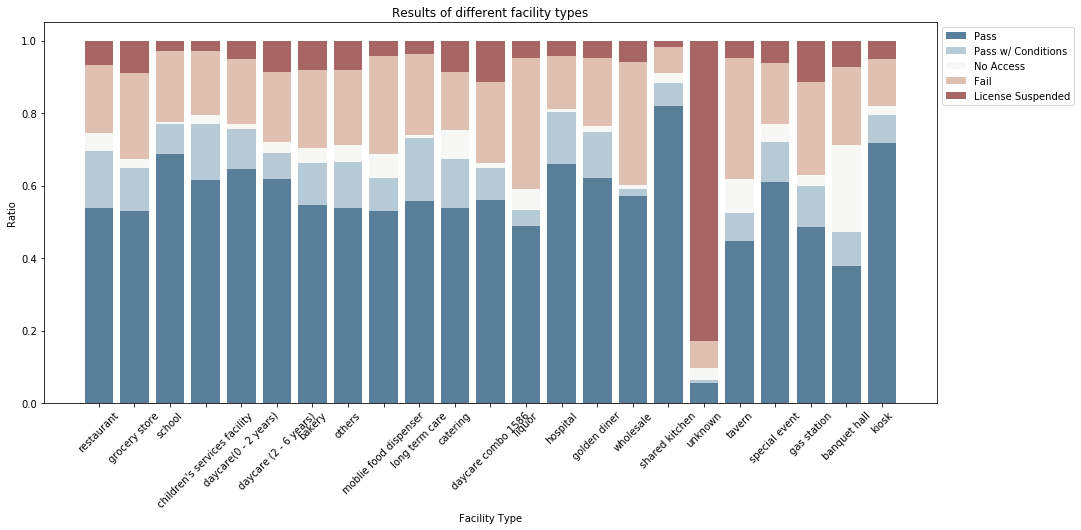

In [47]:
# changes over facility types
num_cols = ['Pass', 'Pass w/ Conditions', 'No Access', 'Fail', 'License Suspended']
per_cols = ['Pass%', 'Pass w/ Conditions%', 'No Access%', 'Fail%', 'License Suspended%']

results_fac = df.groupby(['facility type', 'results'])['results'].count().unstack().astype('Int32')
results_fac['total'] = np.sum(results_fac, axis = 1).astype('Int32')
results_fac = results_fac[['Pass', 'Pass w/ Conditions', 'No Access', 'Fail', 'License Suspended', 'total']]
results_fac = results_fac.replace(np.nan, 0) 
results_fac = results_fac.sort_values(by = ['Pass'], ascending = False) 
results_fac_lists = []

for num_col, per_col in zip(num_cols, per_cols):
    results_fac[per_col] = results_fac[num_col] / results_fac['total']
    results_fac_lists.append(results_fac[per_col])
    
fig = plt.figure(figsize = (16,7))
plt.xticks(rotation = 45)
plt.xlabel('Facility Type')
plt.ylabel('Ratio')
plt.title('Results of different facility types')

pal = sns.color_palette("RdBu_r", n_colors = 5, desat = .5)
plt.bar( results_fac.index, results_fac_lists[0], color = pal[0], label='Pass')
plt.bar( results_fac.index, results_fac_lists[1], color = pal[1], label='Pass w/ Conditions', bottom = results_fac_lists[0])
plt.bar( results_fac.index, results_fac_lists[2], color = pal[2], label='No Access', bottom = results_fac_lists[1]+results_fac_lists[0])
plt.bar( results_fac.index, results_fac_lists[3], color = pal[3], label='Fail', bottom = results_fac_lists[0]+results_fac_lists[1]+results_fac_lists[2])
plt.bar( results_fac.index, results_fac_lists[4], color = pal[4], label='License Suspended', bottom = results_fac_lists[0]+results_fac_lists[1]+results_fac_lists[2]+results_fac_lists[3])
plt.legend(bbox_to_anchor=(1, 1))
plt.show

In [50]:
# save in html
plotly.offline.plot({'data':[
    go.Bar(x = results_fac.index, y = results_fac_lists[0], marker_color = 'SteelBlue', name = num_cols[0]),
    go.Bar(x = results_fac.index, y = results_fac_lists[1], marker_color = 'LightSteelBlue', name = num_cols[1]),
    go.Bar(x = results_fac.index, y = results_fac_lists[2], marker_color = 'SeaShell', name = num_cols[2]),
    go.Bar(x = results_fac.index, y = results_fac_lists[3], marker_color = 'RosyBrown', name = num_cols[3]),
    go.Bar(x = results_fac.index, y = results_fac_lists[4], marker_color = 'IndianRed', name = num_cols[4])
],
    'layout': {'title': 'Results of different facility types', \
               'font': dict(size = 16), \
               'barmode': 'stack'\
}},\
    auto_open = True, \
    filename = './HTML/Results of different facility types', \
    validate = False)

In [51]:
df[df['facility type'] == 'unknown'].groupby('inspection type').size()

inspection type
canvass                    4105
canvass re inspection        14
complaint                    87
complaint re inspection       5
consultation                  8
license                     288
license re inspection        14
others                      222
task force                    2
dtype: int64

In [52]:
df[(df['facility type'] == 'unknown') & (df['inspection type'] == 'canvass') & (df['results'] == 'License Suspended')]

,Inspection ID,DBA Name,License #,Risk,Address,City,State,Zip,Inspection Date,Violations,Latitude,Longitude,facility type,year,month,day,inspection type,results,Pass
393,2320494,extra value co,29630,Risk 3 (Low),7300 N WESTERN AVE,CHICAGO,IL,60645,2019-10-25,NaN,42.014184,-87.690378,unknown,2019,10,25,canvass,License Suspended,0
953,2315750,sports bar white star,24612,Risk 3 (Low),3049 N CICERO AVE,CHICAGO,IL,60641,2019-10-10,NaN,41.936668,-87.746655,unknown,2019,10,10,canvass,License Suspended,0
976,2315749,sports bar white star,1542233,Risk 3 (Low),3049 N CICERO AVE,CHICAGO,IL,60641,2019-10-10,NaN,41.936668,-87.746655,unknown,2019,10,10,canvass,License Suspended,0
1705,2312700,new chicago kimchee,13340,Risk 3 (Low),3648 W LAWRENCE AVE,CHICAGO,IL,60625,2019-09-23,NaN,41.968437,-87.720245,unknown,2019,9,23,canvass,License Suspended,0
1708,2312759,"sanjustins kitchen,inc",2630725,Risk 1 (High),157 W 75th ST,CHICAGO,IL,60620,2019-09-23,NaN,41.758048,-87.629453,unknown,2019,9,23,canvass,License Suspended,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186903,154397,cousin frankies italian ice,1479616,Risk 2 (Medium),444 W FULLERTON PKWY,CHICAGO,IL,60614,2010-06-29,NaN,41.925687,-87.640958,unknown,2010,6,29,canvass,License Suspended,0
187481,251049,campbell food & liquor inc,28448,Risk 3 (Low),2459 W MADISON ST,CHICAGO,IL,60612,2010-06-17,NaN,41.881020,-87.688671,unknown,2010,6,17,canvass,License Suspended,0
187499,251054,neighborhood food mart inc,1479700,Risk 3 (Low),2748 W MADISON ST,CHICAGO,IL,60612,2010-06-17,NaN,41.881191,-87.695806,unknown,2010,6,17,canvass,License Suspended,0
188707,456947,yuriria restaurant y cenaduria,1892401,Risk 1 (High),1632 W 47TH ST,CHICAGO,IL,60609,2010-05-26,NaN,41.808699,-87.666234,unknown,2010,5,26,canvass,License Suspended,0


In [53]:
df[(df['facility type'] == 'unknown') & (df['inspection type'] == 'canvass') & (df['results'] == 'License Suspended')].groupby('year').size()

year
2010     392
2011     514
2012    1148
2013     860
2014     502
2015     204
2016      84
2017     102
2018      35
2019      23
dtype: int64

In [54]:
df[df['facility type'] == 'unknown'].groupby('results').size()

results
Fail                   363
License Suspended     3928
No Access              152
Pass                   260
Pass w/ Conditions      42
dtype: int64

The proportions of inspections results for different facility types are similar. Most of the facility types have a overall pass rate which include result pass and pass with conditions of 60% to 80%. Among all the facility types, school, hospital and shared kitchen have relatively high pass rates. The outlier is type unknown, whose results are mostly license suspended.

#### 2) Changes over districts

How does food sanity condition correlate to district?

We draw a pass rate for districts. There are considerable differences between the pass rates of different districts of Chicago. In the east of the city, which is the city center with the highest facility density, pass rates are above 60%, so the sanitary condition is generally satisfactory. In contrast, on the west side where there are also lots of facilities, the pass rates are only about 45%. In addition, some districts in the north and south part of Chicago also have a clustering effect of low pass rates.

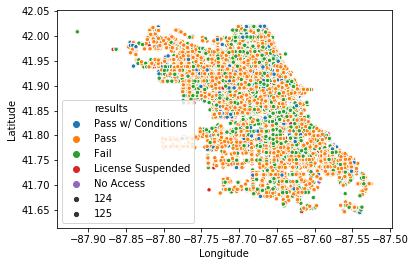

In [55]:
sns.scatterplot(x = 'Longitude',y = 'Latitude',hue = 'results',data = df, size = 125)

In [504]:
df_geo = df.dropna(subset=['Latitude','Longitude'])
dist = gpd.read_file('Neighborhoods_2012/neighbors_shp.shp')

df_geo['cor'] = list(zip(df_geo.Longitude,df_geo.Latitude))
df_geo['cor']= df_geo['cor'].apply(Point)
gdf_geo = gpd.GeoDataFrame(df_geo,geometry = 'cor')

geo_withdist = geopandas.sjoin(gdf_geo, dist, how="inner", op='intersects')
df_geo = pd.DataFrame(geo_withdist)

#Drop The Date 
gdf_new = geo_withdist.copy()
# gdf_new.isnull().sum()
gdf_new = gdf_new[gdf_new['License #'] != 0.0]

gdf_new.crs = {'init':'epsg:4326'}
dist.crs = {'init':'epsg:4326'}

# only remain the newest inspction risk result
gdf_new.sort_values(by='Inspection Date',ascending = False, inplace=True)
gdf_new = gdf_new.groupby(['License #']).head(1)# only take the newest facility inspection risk evaluation

gdf_pass = gdf_new[gdf_new['results'] == 'Pass'   ]
gdf_conpass = gdf_new[gdf_new['results'] == 'Pass w/ Conditions']
gdf_sus = gdf_new[gdf_new['results'] == 'License Suspended']
gdf_fail = gdf_new[gdf_new['results'] == 'Fail']
gdf_no = gdf_new[gdf_new['results'] == 'No Access']

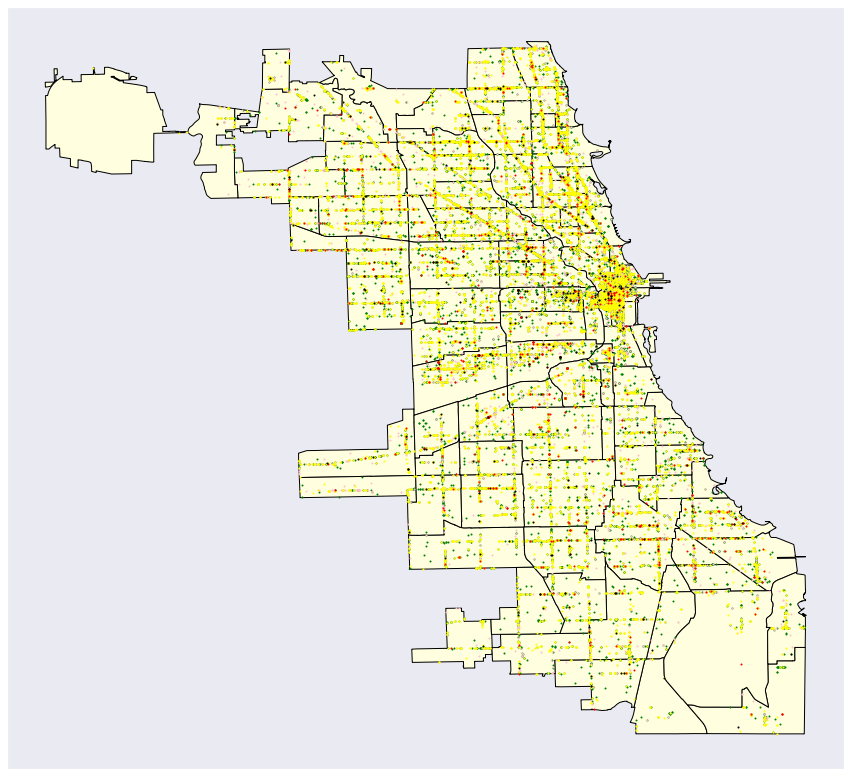

In [512]:
base = dist.plot(color='lightyellow',edgecolor='black',figsize=(15, 15)) 
gdf_pass.plot(ax=base,marker='o', color='green', markersize=1)
gdf_conpass.plot(ax=base,marker='o', color='pink', markersize=1) 
gdf_sus.plot(ax=base,marker='o', color='yellow', markersize=1) 
gdf_fail.plot(ax=base,marker='o', color='red', markersize=1)
gdf_no.plot(ax=base,marker='o', color='black', markersize=1)

plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

Text(0.5, 1, 'Pass Rates of facilities in different districts')

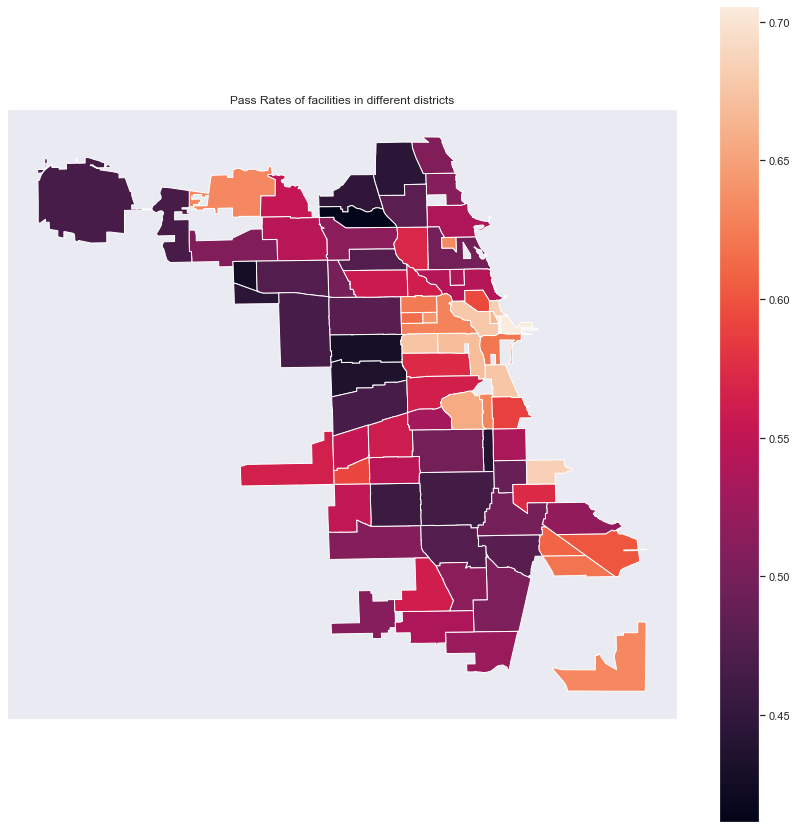

In [517]:
pass_count = gpd.GeoDataFrame(gdf_pass['PRI_NEIGH'].value_counts()).reset_index()
pass_count.columns = ['PRI_NEIGH','Pass']
conpass_count = gpd.GeoDataFrame(gdf_conpass['PRI_NEIGH'].value_counts()).reset_index()
conpass_count.columns = ['PRI_NEIGH','Pass w/ Conditions']
sus_count = gpd.GeoDataFrame(gdf_sus['PRI_NEIGH'].value_counts()).reset_index()
sus_count.columns = ['PRI_NEIGH','License Suspended']
fail_count = gpd.GeoDataFrame(gdf_fail['PRI_NEIGH'].value_counts()).reset_index()
fail_count.columns = ['PRI_NEIGH','Fail']
no_count = gpd.GeoDataFrame(gdf_no['PRI_NEIGH'].value_counts()).reset_index()
no_count.columns = ['PRI_NEIGH','No Access']

dist_pass = dist.copy()
dist_pass = dist_pass.merge(pass_count,on = 'PRI_NEIGH')
dist_pass = dist_pass.merge(conpass_count,on = 'PRI_NEIGH')
dist_pass = dist_pass.merge(sus_count,on = 'PRI_NEIGH')
dist_pass = dist_pass.merge(fail_count,on = 'PRI_NEIGH')
dist_pass = dist_pass.merge(no_count,on = 'PRI_NEIGH')

dist_pass['count'] = dist_pass['Pass'] + dist_pass['Pass w/ Conditions'] + dist_pass['License Suspended'] + dist_pass['Fail'] + dist_pass['No Access']
dist_pass['Total_Pass'] = dist_pass['Pass'] + dist_pass['Pass w/ Conditions']
dist_pass['Total_Fail'] = dist_pass['License Suspended'] + dist_pass['Fail']
dist_pass['Pass_Rate'] = dist_pass['Total_Pass']/dist_pass['count']

base = dist_pass.plot(column='Pass_Rate',legend=True,figsize=(15, 15)) 
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator()) 
plt.title('Pass Rates of facilities in different districts')

In [747]:
results_map=dict({num_cols[0]: 0,
             num_cols[1]: 1,
             num_cols[2]: 2,
             num_cols[3]: 3,
             num_cols[4]: 4,})

df['results_num'] = df['results']
df['results_num'] = df['results_num'].map(results_map)

# Create dimensions
facility_dim = go.parcats.Dimension(
    values = df['facility type'],
    label = "Facility Type"
)

inspection_dim = go.parcats.Dimension(
    values = df['inspection type'],
    label = "Inspection Type"
)

results_dim = go.parcats.Dimension(
  values = df['results_num'],
  label = "Results",
  categoryarray = [0, 1, 2, 3, 4],
  ticktext = num_cols,
)

# Create parcats trace
color = df.results_num
colorscale = [[0, colors5[0]], [0.25, colors5[1]], [0.5, colors5[2]], [0.75, colors5[3]], [1, colors5[4]]]

plotly.offline.plot({'data': [
    go.Parcats(
        dimensions = [facility_dim, inspection_dim, results_dim],
        line = {'color': color,
              'colorscale': colorscale}
    )],
    'layout': {'title': 'facility-inspection-results',
               'font': dict(size = 16),
}},\
    auto_open = True, \
    filename = './HTML/facility-inspection-results.html',
    validate = False)    

'./HTML/facility-inspection-results.html'

#### 3) Changes over time

How does food sanity condition correlate to time?

To answer this question, we performed analysis yearly and monthly. From the stack plot, a sudden decrease happened between 2017 and 2018, which might due to the changes of inspection methods in 1/7/2018. It's said their new inspection methods may be more stricter than the previous one. Besides, pass rate and fail rate basicly keep the same over years, except for 2012 where had a relatively low pass rate and relatively hight fail rate. For the changes between 2017 and 2018, we would discuss it later.

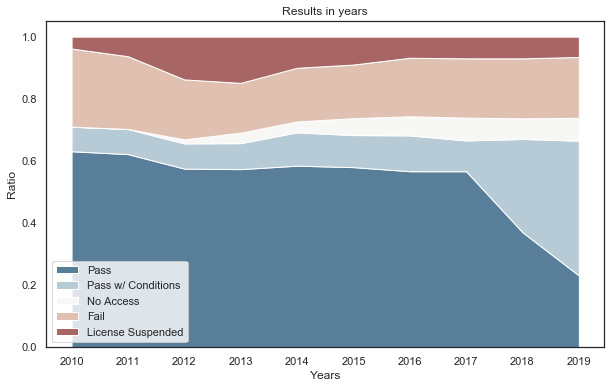

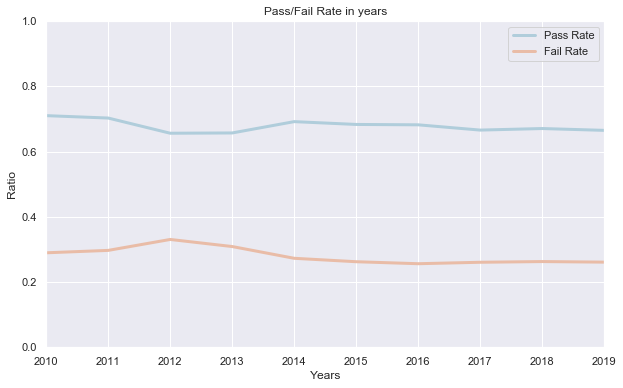

In [190]:
# changes over years
num_cols = ['Pass', 'Pass w/ Conditions', 'No Access', 'Fail', 'License Suspended']
per_cols = ['Pass%', 'Pass w/ Conditions%', 'No Access%', 'Fail%', 'License Suspended%']

results_year = df.groupby(['year', 'results'])['results'].count().unstack().astype('Int32')
results_year['total'] = np.sum(results_year, axis = 1).astype('Int32')
results_year = results_year[['Pass', 'Pass w/ Conditions', 'No Access', 'Fail', 'License Suspended', 'total']]
results_year = results_year.replace(np.nan, 0) 
results_year_lists = []

for num_col, per_col in zip(num_cols, per_cols):
    results_year[per_col] = results_year[num_col] / results_year['total']
    results_year_lists.append(results_year[per_col])
    
fig = plt.figure(figsize = (10, 6))
sns.set(style = "white")
pal = sns.color_palette("RdBu_r", n_colors = 5, desat = .5)
plt.stackplot(results_year.index, results_year_lists, colors = pal, labels = num_cols)
plt.xlabel('Years')
plt.ylabel('Ratio')
plt.title('Results in years')
plt.xticks(range(2010, 2020))
plt.legend(loc = 'lower left')
plt.show()

fig = plt.figure(figsize = (10, 6))
sns.set(style = "darkgrid")
pal = sns.color_palette("RdBu_r", n_colors = 2, desat = .7)
(results_year['Pass%'] + results_year['Pass w/ Conditions%']).plot(label = 'Pass Rate', color = pal[0], linewidth = 3)
(results_year['Fail%'] + results_year['License Suspended%']).plot(label = 'Fail Rate', color = pal[1], linewidth = 3)
plt.xlabel('Years')
plt.ylabel('Ratio')
plt.ylim(0, 1)
plt.xticks(range(2010, 2020))
plt.title('Pass/Fail Rate in years')
plt.legend(loc = 'best')
plt.show()

In [686]:
# save in html
plotly.offline.plot({'data':[
    go.Bar(x = results_fac.index, y = results_fac_lists[0], marker_color = 'SteelBlue', name = num_cols[0], orientation='h'),
    go.Bar(x = results_fac.index, y = results_fac_lists[1], marker_color = 'LightSteelBlue', name = num_cols[1]),
    go.Bar(x = results_fac.index, y = results_fac_lists[2], marker_color = 'SeaShell', name = num_cols[2]),
    go.Bar(x = results_fac.index, y = results_fac_lists[3], marker_color = 'RosyBrown', name = num_cols[3]),
    go.Bar(x = results_fac.index, y = results_fac_lists[4], marker_color = 'IndianRed', name = num_cols[4])
],
    'layout': {'title': 'Results of different facility types', \
               'font': dict(size = 16), \
               'barmode': 'stack'\
}},\
    auto_open = True, \
    filename = './HTML/Results of different facility types', \
    validate = False)              

'./HTML/Results of different facility types.html'

We hope to find a pattern behind months. From the second figure, the approximate trend is that fail rate increases the same time as month increases which is not what we expected. But if we only look at `pass` at the first figure, there is an obvious drop from July to September which indicates more critical or serious problems would appear in hot weather.

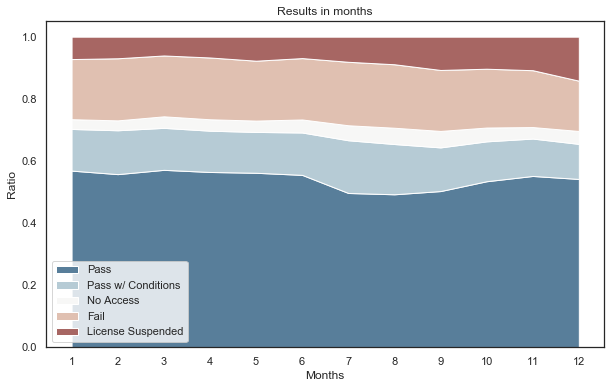

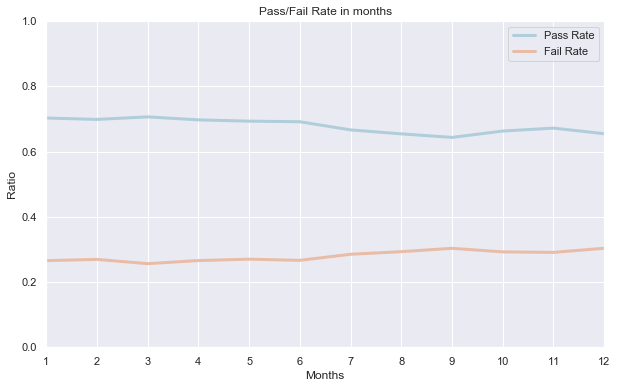

In [192]:
# changes over months
results_month = df.groupby(['month', 'results'])['results'].count().unstack().astype('Int32')
results_month['total'] = np.sum(results_month, axis = 1).astype('Int32')
results_month = results_month[['Pass', 'Pass w/ Conditions', 'No Access', 'Fail', 'License Suspended', 'total']]
results_month = results_month.replace(np.nan, 0) 
results_month_lists = []

for num_col, per_col in zip(num_cols, per_cols):
    results_month[per_col] = results_month[num_col] / results_month['total']
    results_month_lists.append(results_month[per_col])

fig = plt.figure(figsize = (10, 6))
sns.set(style = "white")
pal = sns.color_palette("RdBu_r", n_colors = 5, desat = .5)
plt.stackplot(results_month.index, results_month_lists, colors = pal, labels = num_cols)
plt.xlabel('Months')
plt.ylabel('Ratio')
plt.title('Results in months')
plt.xticks(range(1, 13))
plt.legend(loc = 'lower left')
plt.show()

fig = plt.figure(figsize = (10, 6))
sns.set(style = "darkgrid")
pal = sns.color_palette("RdBu_r", n_colors = 2, desat = .7)
(results_month['Pass%'] + results_month['Pass w/ Conditions%']).plot(label = 'Pass Rate', color = pal[0], linewidth = 3)
(results_month['Fail%'] + results_month['License Suspended%']).plot(label = 'Fail Rate', color = pal[1], linewidth = 3)
plt.xlabel('Months')
plt.ylabel('Ratio')
plt.title('Pass/Fail Rate in months')
plt.ylim(0, 1)
plt.xticks(range(1, 13))
plt.legend(loc = 'best')
plt.show()

Consider violation rate from 1 to 29 which implies critical and serious violation and may create immediate or potential health hazard. From the plot below, its rate has a significant increase between June and September when Chicago has the supper hot weather. 

Now, considering the following situation: purely pass rate decreases, pass rate keeps the same, and critical & serious rate increases, whose corresonding explanation is: establishments have more critical and serious food safety problems but they would not take care of them in daily life and could correct these violation during the inspection. What a threatening food safety condition! 

Therefore, combining pass rate, purely pass rate, and critical & serious rate, we can say that the sanity condition of food establishments is indeed worse in hot weather.

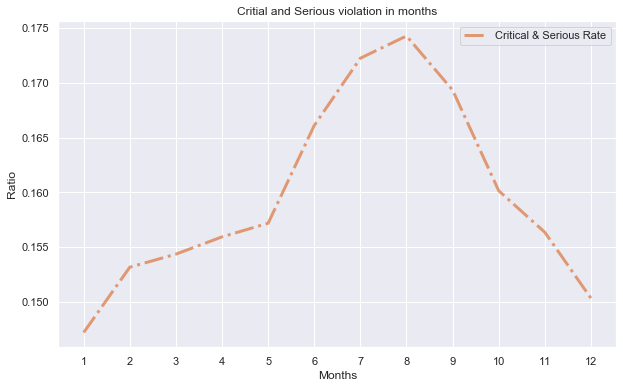

In [282]:
# replace 0.0 in 46 violation numbers with np.nan
df_vio1_nan = df_vio1.copy().replace(0.0, np.nan)
month_pass = df_vio1_nan.groupby(['month', 'results']).count()
month_pass = month_pass.loc[:, 'vio1':'vio46'].reset_index(['results'])

month_pass['critical #'] = month_pass.loc[:, 'vio1': 'vio14'].sum(axis = 1)
month_pass['serious #'] = month_pass.loc[:, 'vio15': 'vio29'].sum(axis = 1)
month_pass['minor #'] = month_pass.loc[:, 'vio30': 'vio46'].sum(axis = 1)
month_pass['total #'] = month_pass.loc[:, 'critical #': 'minor #'].sum(axis = 1)

month_pass = month_pass.groupby('month').sum()
month_pass['cs %'] = (month_pass['critical #'] + month_pass['serious #']) / month_pass['total #']

fig = plt.figure(figsize = (10, 6))
sns.set(style = "darkgrid")
pal = sns.color_palette("RdBu_r", n_colors = 2, desat = .7)
plt.plot(month_pass.index, month_pass['cs %'], 'C1-.', label = 'Critical & Serious Rate', linewidth = 3, alpha = 0.8)
plt.xlabel('Months')
plt.ylabel('Ratio')
plt.title('Critial and Serious violation in months')
plt.xticks(range(1, 13))
plt.legend(loc = 'best')
plt.show()

### 2.2 Evaluation of Inspection Methods

Things related to inspection methods are inspetion type, inspection frequency (which is related to `Risk` for `canvass`), and the changes to food inspection procedures. So we gonna dive into these three parts to evaluate the inspection methods.

#### 1) Inspection Type

We first check the distribution of inspection type. `Canvass` takes up the majority share of different types while the second common type is `license` and the third one is `complaint`, followed by their re-inspections. The rest are nearly zero.

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], <a list of 11 Text xticklabel objects>)

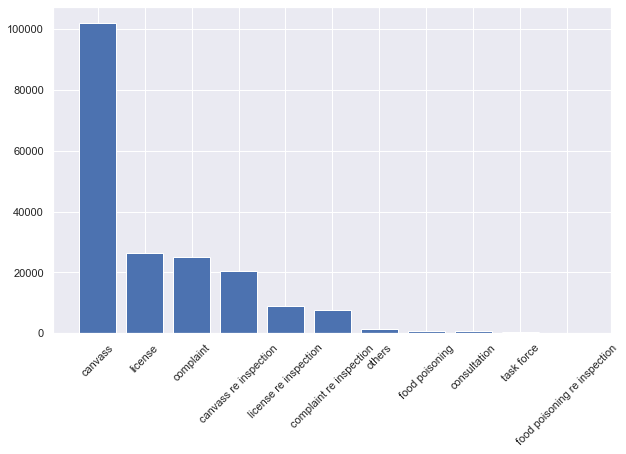

In [300]:
ins_type = df.groupby('inspection type').size().sort_values(ascending = False)
fig = plt.figure(figsize = (10, 6))
plt.bar(ins_type.index, ins_type.values)
plt.xticks(rotation = 45)

For each inspection type, their distribution in results changes a lot. To find a pattern, we placed re-inpsections together so it's clear that re-inspections would have highest purely pass rate and lowest fail rate.

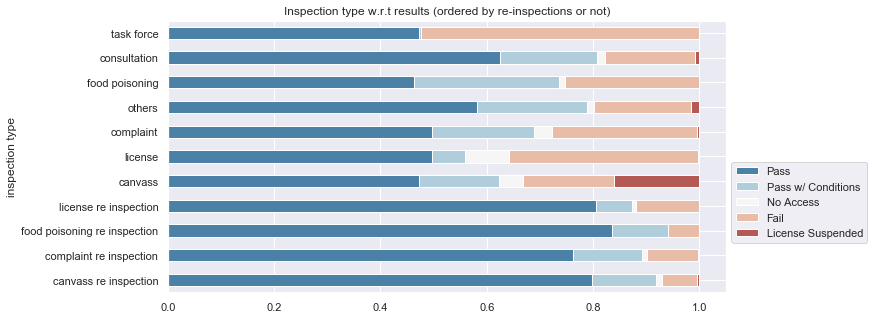

In [357]:
ins_type_result = df.groupby('inspection type')['results']
ins_type_result = pd.DataFrame(ins_type_result.apply(lambda x:x.value_counts())).unstack()['results'].fillna(0)
ins_type_result['total number'] = ins_type_result.values.sum(axis = 1)
ins_type_result['order by num'] = [1, 4, 3, 6, 9, 8, 11, 2, 5, 7, 10]
ins_type_result['order by re'] = [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1]

for i in ins_type_result.columns:
    if i != 'total number':
        ins_type_result[i] = ins_type_result[i] / ins_type_result['total number']
        
ins_type_result_by_re = ins_type_result.sort_values(by = ['order by re'])[['Pass','Pass w/ Conditions', 'No Access', 'Fail', 'License Suspended']]

pal = sns.color_palette("RdBu_r", n_colors = 5, desat = .7)
sns.set(style = "darkgrid")
ins_type_result_by_re.plot.barh(stacked = True, colors = pal, figsize = (10, 5))
plt.title('Inspection type w.r.t results (ordered by re-inspections or not)')
plt.legend(bbox_to_anchor = (1, 0.5))

In [691]:
ins_type_result_by_re[num_cols[0]]

inspection type
canvass re inspection           0.798282
complaint re inspection         0.761740
food poisoning re inspection    0.835979
license re inspection           0.806353
canvass                         0.490876
license                         0.500981
complaint                       0.498937
others                          0.583133
food poisoning                  0.463270
consultation                    0.628225
task force                      0.475655
Name: Pass, dtype: float64

In [693]:
colors5 = ['SteelBlue', 'LightSteelBlue', 'SeaShell', 'RosyBrown', 'IndianRed']

In [694]:
# save in html
plotly.offline.plot({'data':[
    go.Bar(y = ins_type_result_by_re.index, x = ins_type_result_by_re[num_cols[0]].values, marker_color = colors5[0], name = num_cols[0], orientation = 'h'),
    go.Bar(y = ins_type_result_by_re.index, x = ins_type_result_by_re[num_cols[1]], marker_color = colors5[1], name = num_cols[1], orientation = 'h'),
    go.Bar(y = ins_type_result_by_re.index, x = ins_type_result_by_re[num_cols[2]], marker_color = colors5[2], name = num_cols[2], orientation = 'h'),
    go.Bar(y = ins_type_result_by_re.index, x = ins_type_result_by_re[num_cols[3]], marker_color = colors5[3], name = num_cols[3], orientation = 'h'),
    go.Bar(y = ins_type_result_by_re.index, x = ins_type_result_by_re[num_cols[4]], marker_color = colors5[4], name = num_cols[4], orientation = 'h')
],
    'layout': {'title': 'Inspection type w.r.t results (ordered by re-inspections or not)', \
               'font': dict(size = 16), \
               'barmode': 'stack'\
}},\
    auto_open = True, \
    filename = './HTML/Inspection type w.r.t results (ordered by re-inspections or not)', \
    validate = False)              

'./HTML/Inspection type w.r.t results (ordered by re-inspections or not).html'

We redraw the figure above ordered by distribution of inspection number.

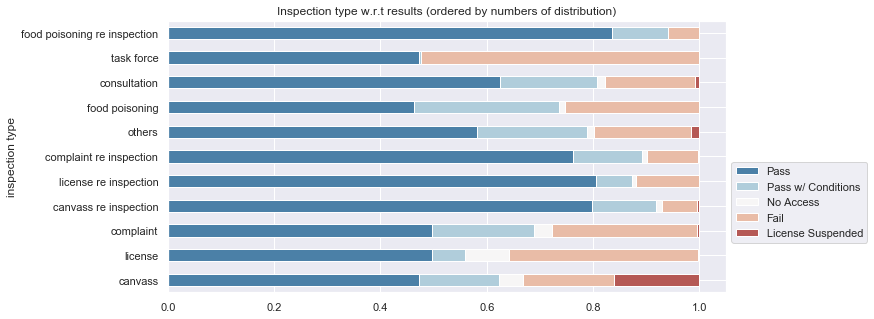

In [359]:
ins_type_result_by_num = ins_type_result.sort_values(by = ['order by num'])[['Pass','Pass w/ Conditions', 'No Access', 'Fail', 'License Suspended']]

pal = sns.color_palette("RdBu_r", n_colors = 5, desat = .7)
sns.set(style = "darkgrid")
ins_type_result_by_num.plot.barh(stacked = True, colors = pal, figsize = (10,5))
plt.title('Inspection type w.r.t results (ordered by numbers of distribution)')
plt.legend(bbox_to_anchor = (1, 0.5))

In [696]:
# save in html
plotly.offline.plot({'data':[
    go.Bar(y = ins_type_result_by_num.index, x = ins_type_result_by_num[num_cols[0]].values, marker_color = colors5[0], name = num_cols[0], orientation = 'h'),
    go.Bar(y = ins_type_result_by_num.index, x = ins_type_result_by_num[num_cols[1]], marker_color = colors5[1], name = num_cols[1], orientation = 'h'),
    go.Bar(y = ins_type_result_by_num.index, x = ins_type_result_by_num[num_cols[2]], marker_color = colors5[2], name = num_cols[2], orientation = 'h'),
    go.Bar(y = ins_type_result_by_num.index, x = ins_type_result_by_num[num_cols[3]], marker_color = colors5[3], name = num_cols[3], orientation = 'h'),
    go.Bar(y = ins_type_result_by_num.index, x = ins_type_result_by_num[num_cols[4]], marker_color = colors5[4], name = num_cols[4], orientation = 'h')
],
    'layout': {'title': 'Inspection type w.r.t results (ordered by numbers of distribution)', \
               'font': dict(size = 16), \
               'barmode': 'stack'\
}},\
    auto_open = True, \
    filename = './HTML/Inspection type w.r.t results (ordered by numbers of distribution).html', \
    validate = False)              

'./HTML/Inspection type w.r.t results (ordered by numbers of distribution).html'

What's more, one of the suprising results is that `license` inspection actually has the lowest pass rate. Since in `license` inspection, a health inspector from the CDPH will contact the applicant to arrange for an inspection while the rests inspection types are unannounced inspetions. For us, results from announced inspection should be better than that of unannouced inspection where establishments have no time to prepare for the inspection. Thinking through, we think it's probably because applicants are unfamiliar with the requirement of CDPH when the first time they started their business.

We also check what is the re-inspection ratio of each inspection type. Three possible situations are listed as follows:

* re-inspection rate = fail rate: For every fail result in the first inspection, it is re-inspected and passed the first re-inspection.
* re-inspection rate > fail rate: For every fail result in the first inspection, it is re-inspected and some of them did not pass the first re-inspection.
* re-inspection rate < fail rate: For every fail result in the first inspection, it is partially re-inspected.

So applying these situations in the following figure, `complaint` inspection has the highest fail ratio and and also highest?
we may draw a conclusion that 
Note that we do not consider `license` inspection since it is compulsory.


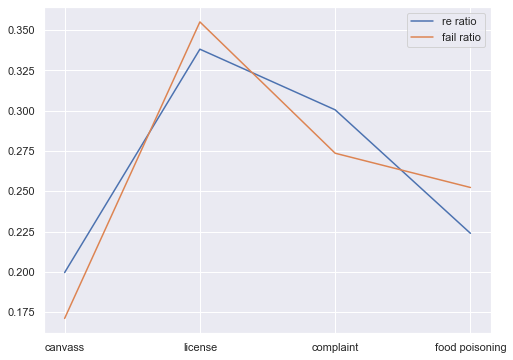

In [536]:
ins_type_ratio = pd.DataFrame(columns = ['re ratio', 'fail ratio'])
ins_type_ratio.loc['canvass', 're ratio'] = ins_type['canvass re inspection'] / ins_type['canvass']
ins_type_ratio.loc['license', 're ratio'] = ins_type['license re inspection'] / ins_type['license']
ins_type_ratio.loc['complaint', 're ratio'] = ins_type['complaint re inspection'] / ins_type['complaint']
ins_type_ratio.loc['food poisoning', 're ratio'] = ins_type['food poisoning re inspection'] / ins_type['food poisoning']
ins_type_ratio.loc['consultation', 're ratio'] = 0
ins_type_ratio.loc['task force', 're ratio'] = 0

ins_type_ratio.loc['canvass', 'fail ratio'] = ins_type_result.loc['canvass', 'Fail']
ins_type_ratio.loc['license', 'fail ratio'] = ins_type_result.loc['license', 'Fail']
ins_type_ratio.loc['complaint', 'fail ratio'] = ins_type_result.loc['complaint', 'Fail']
ins_type_ratio.loc['food poisoning', 'fail ratio'] = ins_type_result.loc['food poisoning', 'Fail']
ins_type_ratio.loc['consultation', 'fail ratio'] = ins_type_result.loc['consultation', 'Fail']
ins_type_ratio.loc['task force', 'fail ratio'] = ins_type_result.loc['task force', 'Fail']

ins_type_ratio['increase ratio'] = (ins_type_ratio['re ratio'] - ins_type_ratio['fail ratio']) / ins_type_ratio['fail ratio']

fig = plt.figure(figsize = (8, 6))
plt.plot(ins_type_ratio.loc['canvass': 'food poisoning', 're ratio'], label = 're ratio')
plt.plot(ins_type_ratio.loc['canvass': 'food poisoning', 'fail ratio'], label = 'fail ratio')
plt.legend()

In [610]:
ins_type_ratio.loc['canvass': 'food poisoning', :]

,re ratio,fail ratio,increase ratio
canvass,0.199583,0.17112,0.166333
license,0.338177,0.355103,-0.047665
complaint,0.300555,0.273624,0.0984229
food poisoning,0.223934,0.25237,-0.112676


#### 2) Inspection frequency

(a). Real Inspection Frequency

As Chicago's government policy:

_In general, risk 1 establishments are inspected twice per year,risk 2 establishments once per year, and risk 3 establishments every other year._

So we are wondering if the inspection frequency really satisfys the state's requirement? If yes, is the frequency reasonable?

The way we calculate inspection frequency is by averaging the total inspection times over its active year which is defined as from the first time doing the `canvass` inspection to the last time doing that. Note that here we only consider `canvass` inspection because this is the only type related to `risk`.


C:\Users\Danya\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Danya\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


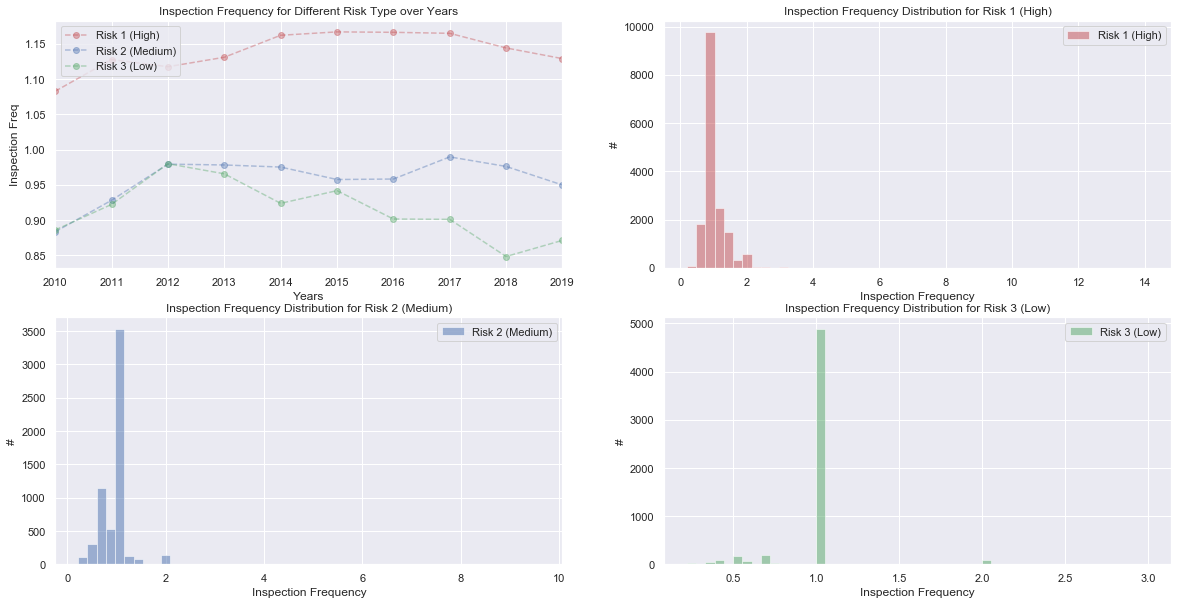

In [417]:
df_canv = df[df['inspection type'] == 'canvass']

risk_freq_gb = df_canv.groupby(['Risk', 'License #'])['year']
risk_freq_df = (risk_freq_gb.count() / (risk_freq_gb.max() - risk_freq_gb.min() + 1)).unstack().T

risk_freq = pd.merge(pd.DataFrame(risk_freq_gb.count() / (risk_freq_gb.max() - risk_freq_gb.min() + 1)).reset_index(['License #', 'Risk']), \
                     pd.DataFrame(risk_freq_gb.apply(lambda x: x.values)).reset_index(['License #', 'Risk']), \
                     on = ['License #', 'Risk'])
risk_freq.columns = ['Risk', 'License #', 'freq', 'year']
risk_freq = risk_freq.explode('year')

risk_freq_year = pd.DataFrame(columns = risks, index = risk_freq.year.unique())
risk_freq_year[risks[0]] = risk_freq[risk_freq['Risk'] == risks[0]].groupby('year').agg({'freq': np.mean}).freq
risk_freq_year[risks[1]] = risk_freq[risk_freq['Risk'] == risks[1]].groupby('year').agg({'freq': np.mean}).freq
risk_freq_year[risks[2]] = risk_freq[risk_freq['Risk'] == risks[2]].groupby('year').agg({'freq': np.mean}).freq
risk_freq_year.sort_index(inplace = True)

risks = ['Risk 1 (High)', 'Risk 2 (Medium)', 'Risk 3 (Low)']
style = ['ro--', 'bo--', 'go--']

fig = plt.figure(figsize = (20, 10))
ax1 = fig.add_subplot(221)
risk_freq_year[risks[0]].plot(style = style[0], alpha = 0.4, label = risks[0])
risk_freq_year[risks[1]].plot(style = style[1], alpha = 0.4, label = risks[1])
risk_freq_year[risks[2]].plot(style = style[2], alpha = 0.4, label = risks[2])
plt.xlabel('Years')
plt.ylabel('Inspection Freq')
plt.title('Inspection Frequency for Different Risk Type over Years')
plt.legend(loc = 2)

ax2 = fig.add_subplot(222)
plt.hist(risk_freq_df[risks[0]], label= risks[0], color = 'r', alpha = 0.5, bins = 50)
plt.xlabel('Inspection Frequency')
plt.ylabel('#')
plt.title('Inspection Frequency Distribution for ' + risks[0])
plt.legend(loc = 1) 

ax3 = fig.add_subplot(223)
plt.hist(risk_freq_df[risks[1]], label= risks[1], color = 'b', alpha = 0.5, bins = 50)
plt.xlabel('Inspection Frequency')
plt.ylabel('#')
plt.title('Inspection Frequency Distribution for ' + risks[1])
plt.legend(loc = 1) 

ax4 = fig.add_subplot(224)
plt.hist(risk_freq_df[risks[2]], label= risks[2], color = 'g', alpha = 0.5, bins = 50)
plt.xlabel('Inspection Frequency')
plt.ylabel('#')
plt.title('Inspection Frequency Distribution for ' + risks[2])
plt.legend(loc = 1) 

We first look at the inspection frequency changes over years, they primarily obey the order with risk 1 being the most frequent and risk 3 being the least, but there is no very clear distinction between risk 2 and 3 especially for the first two years. However, although the frequency basically obey the order, for almost every year, the frequency of inspections is far away from what the government requires for risk 1 while it is totally opposite for risk 3. We can also have almost the same conclusions from the mean inspection frequency for each risk type by averaging yearly data or by averaging data for each license.

In [383]:
print('For each risk type, the average inspection frequency of all years are: \n', risk_freq_df.mean(axis = 0))

For each risk type, the average inspection frequency of all years are: 
 Risk
Risk 1 (High)      1.070255
Risk 2 (Medium)    0.932088
Risk 3 (Low)       0.966423
dtype: float64


In [402]:
risk_freq_year.mean()

Risk 1 (High)      1.139336
Risk 2 (Medium)    0.957507
Risk 3 (Low)       0.914061
dtype: float64

We think the inspection frequency is also related to inspection period. Considering the period for `risk 3` is two years, so if one establishment only do their business for one year, it would not make sense if we count them in. But for other type of risk, their inspection period is equal or less than one year, it would not cause serious impacts if we included them. We can gain some insight into it from the distribution for `risk 3`. 

After dropping those only lived for one year for `risk 3`, we redraw the inspection frequency for different risk type over years. Now it makes more sense to us although the value for `risk 3` is still higher than 0.5. 

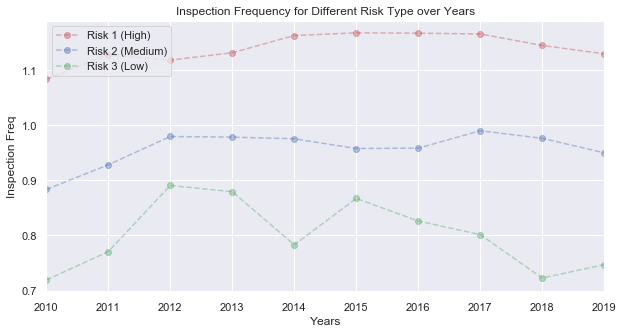

In [446]:
risk_freq_3no1 = pd.merge(pd.DataFrame(risk_freq_gb.count() / (risk_freq_gb.max() - risk_freq_gb.min() + 1)).reset_index(['License #', 'Risk']), \
                          pd.DataFrame(risk_freq_gb.apply(lambda x: x.values)).reset_index(['License #', 'Risk']), \
                          on = ['License #', 'Risk'])
risk_freq_3no1.columns = ['Risk', 'License #', 'freq', 'year']
risk_freq_3no1 = risk_freq_3no1[~((risk_freq_3no1['Risk'].apply(lambda x: x == risks[2])) & ((risk_freq_3no1['year'].apply(lambda x: len(x) <= 1))))]

risk_freq_3no1 = risk_freq_3no1.explode('year')

risk_freq_year_3no1 = pd.DataFrame(columns = risks, index = risk_freq_3no1.year.unique())
risk_freq_year_3no1[risks[0]] = risk_freq_3no1[risk_freq_3no1['Risk'] == risks[0]].groupby('year').agg({'freq': np.mean}).freq
risk_freq_year_3no1[risks[1]] = risk_freq_3no1[risk_freq_3no1['Risk'] == risks[1]].groupby('year').agg({'freq': np.mean}).freq
risk_freq_year_3no1[risks[2]] = risk_freq_3no1[risk_freq_3no1['Risk'] == risks[2]].groupby('year').agg({'freq': np.mean}).freq
risk_freq_year_3no1.sort_index(inplace = True)

risks = ['Risk 1 (High)', 'Risk 2 (Medium)', 'Risk 3 (Low)']
style = ['ro--', 'bo--', 'go--']

fig = plt.figure(figsize = (10, 5))
risk_freq_year_3no1[risks[0]].plot(style = style[0], alpha = 0.4, label = risks[0])
risk_freq_year_3no1[risks[1]].plot(style = style[1], alpha = 0.4, label = risks[1])
risk_freq_year_3no1[risks[2]].plot(style = style[2], alpha = 0.4, label = risks[2])
plt.xlabel('Years')
plt.ylabel('Inspection Freq')
plt.title('Inspection Frequency for Different Risk over Years')
plt.legend(loc = 2)

In [488]:
print('For each risk type, the new average inspection frequency of all years are: \n ', risk_freq_year_3no1.mean(axis = 0))

For each risk type, the new average inspection frequency of all years are: 
  Risk 1 (High)      1.139336
Risk 2 (Medium)    0.957507
Risk 3 (Low)       0.800800
dtype: float64


But now consider how many establishments we have dropped, that is 4754, which takes up 84% of the establishments being `risk 3`. It would not be reasonable for having only 16% of data, but it can give us some clues for understanding the inspection frequency for `risk 3`!

In [485]:
risk_period = (risk_freq_gb.max() - risk_freq_gb.min() + 1).unstack().T
# drop those risk could change
risk_period = risk_period[risk_period.count(axis = 1) == 1]

print(risk_period[risks[2]].count(), 'establishments are risk 3 (low).')
print((risk_period[risks[2]] == 1.0).sum(), 'establishments only live equal or less than one year.')
print(risk_period[risks[2]].count() - (risk_period[risks[2]] == 1.0).sum(), 'establishments live greater than one year.')

5607 establishments are risk 3 (low).
4754 establishments only live equal or less than one year.
853 establishments live greater than one year.


The conclusion for real inspection frequency is that there is a slight difference among different risk.

* The real inspection frequency for risk 1 is around 1.13.
* The real inspection frequency for risk 2 is around 0.95.
* The real inspection frequency for risk 3 is around 0.80.

Besides, the inspectors really do not follow what they are asked to do! News https://www.chicagotribune.com/business/ct-chicago-restaurant-inspections-1130-biz-20161129-story.html also reflects our consideration.

(b). Relationship between Inspection Frequency and Results

The relationship between risks and results in figure below tells us pass rate would increase and fail rate would decrease if risk decreases. The conclusion may not be very convincible because of the exsitence of different inspection frequency. If the claim is right, we should observe that with increasing of inspesction frequency, pass rate in results should decrease. So it's expected to have a reverse relationship between inspection frequency and pass rate. However, no matter in? 

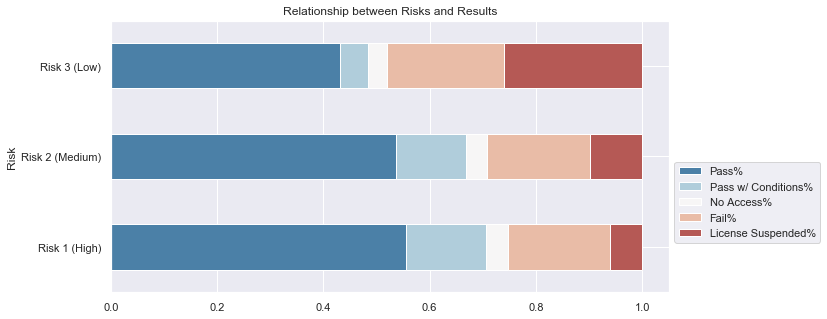

In [497]:
risk_results = df.groupby('Risk')['results'].value_counts().unstack()
risk_results = risk_results[['Pass', 'Pass w/ Conditions', 'No Access', 'Fail', 'License Suspended']]
risk_results['total'] = risk_results.sum(axis = 1)
risk_results['Pass%'] = risk_results['Pass'] / risk_results['total']
risk_results['Pass w/ Conditions%'] = risk_results['Pass w/ Conditions'] / risk_results['total']
risk_results['No Access%'] = risk_results['No Access'] / risk_results['total']
risk_results['Fail%'] = risk_results['Fail'] / risk_results['total']
risk_results['License Suspended%'] = risk_results['License Suspended'] / risk_results['total']

pal = sns.color_palette("RdBu_r", n_colors = 5, desat = .7)
sns.set(style = "darkgrid")
risk_results.loc[:, 'Pass%': 'License Suspended%'].plot.barh(stacked = True, colors = pal, figsize = (10,5))
plt.title('Relationship between Risks and Results')
plt.legend(bbox_to_anchor = (1, 0.5))

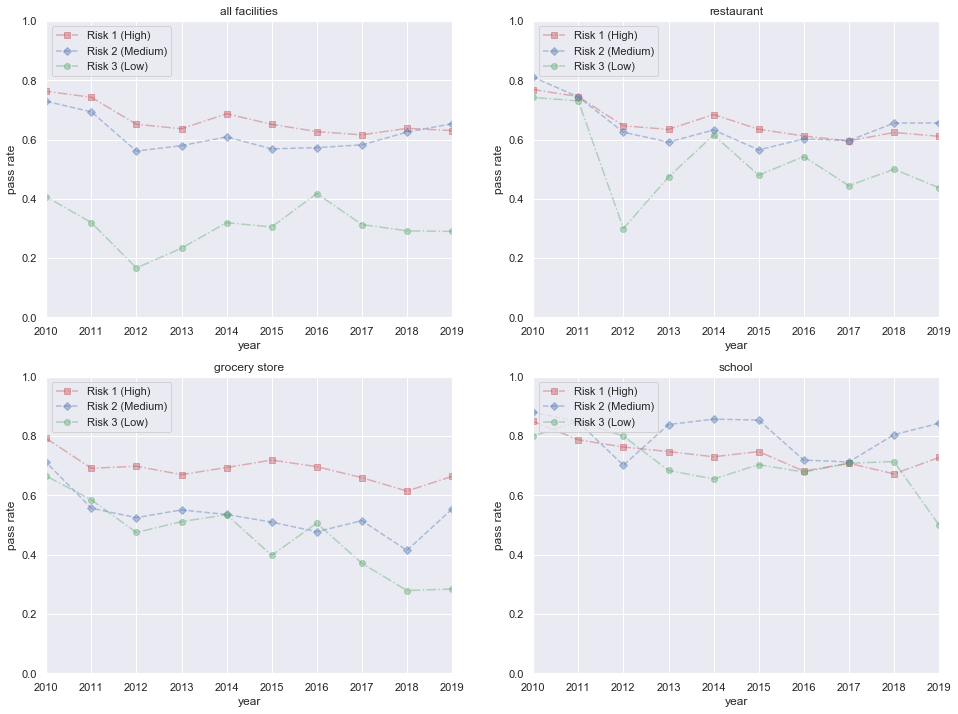

In [520]:
fac_eg = ['all facilities', 'restaurant', 'grocery store', 'school']
year = df_canv['year'].unique().tolist()

risk_pass_rate = []
for i in year:
    year_i = df_canv[df_canv['year'] == i]
    risk_1 = year_i[year_i['Risk'] == risks[0]]
    risk_2 = year_i[year_i['Risk'] == risks[1]]
    risk_3 = year_i[year_i['Risk'] == risks[2]]
    for j in fac_eg:
        if j == 'all facilities':
            risk_pass_rate.append([i, j, risk_1[(risk_1['results'] == 'Pass') | (risk_1['results'] == 'Pass w/ Conditions')].shape[0] / risk_1.shape[0], \
                                         risk_2[(risk_2['results'] == 'Pass') | (risk_2['results'] == 'Pass w/ Conditions')].shape[0] / risk_2.shape[0], \
                                         risk_3[(risk_3['results'] == 'Pass') | (risk_3['results'] == 'Pass w/ Conditions')].shape[0] / risk_3.shape[0]])
        else:
            risk_pass_rate.append([i, j, risk_1[(risk_1['facility type'] == j) & ((risk_1['results'] == 'Pass') | (risk_1['results'] == 'Pass w/ Conditions'))].shape[0] / risk_1[risk_1['facility type'] == j].shape[0], \
                                         risk_2[(risk_2['facility type'] == j) & ((risk_2['results'] == 'Pass') | (risk_2['results'] == 'Pass w/ Conditions'))].shape[0] / risk_2[risk_2['facility type'] == j].shape[0], \
                                         risk_3[(risk_3['facility type'] == j) & ((risk_3['results'] == 'Pass') | (risk_3['results'] == 'Pass w/ Conditions'))].shape[0] / risk_3[risk_3['facility type'] == j].shape[0]])
                                   
risk_pass_rate = pd.DataFrame(risk_pass_rate)
risk_pass_rate.columns = ['year', 'facility type', 'risk1', 'risk2', 'risk3']
risk_pass_rate = risk_pass_rate.set_index(['year'])


fig = plt.figure(figsize = (16, 12))
fac_eg = ['all facilities', 'restaurant', 'grocery store', 'school']
style = ['rs-.', 'bD--', 'go-.']

for i, j in enumerate(fac_eg):
    fig_num = 221 + i
    ax = fig.add_subplot(fig_num)
    for m, n in enumerate(risks):
        risk = 'risk' + str(m + 1)
        risk_pass_rate[risk_pass_rate['facility type'] == j][risk].plot(ax = ax, style = style[m], alpha = 0.4, label = n)
    plt.title(j)
    plt.xlabel('year') 
    plt.ylabel('pass rate')
    plt.ylim(0,1)
    plt.legend(loc = 2)       

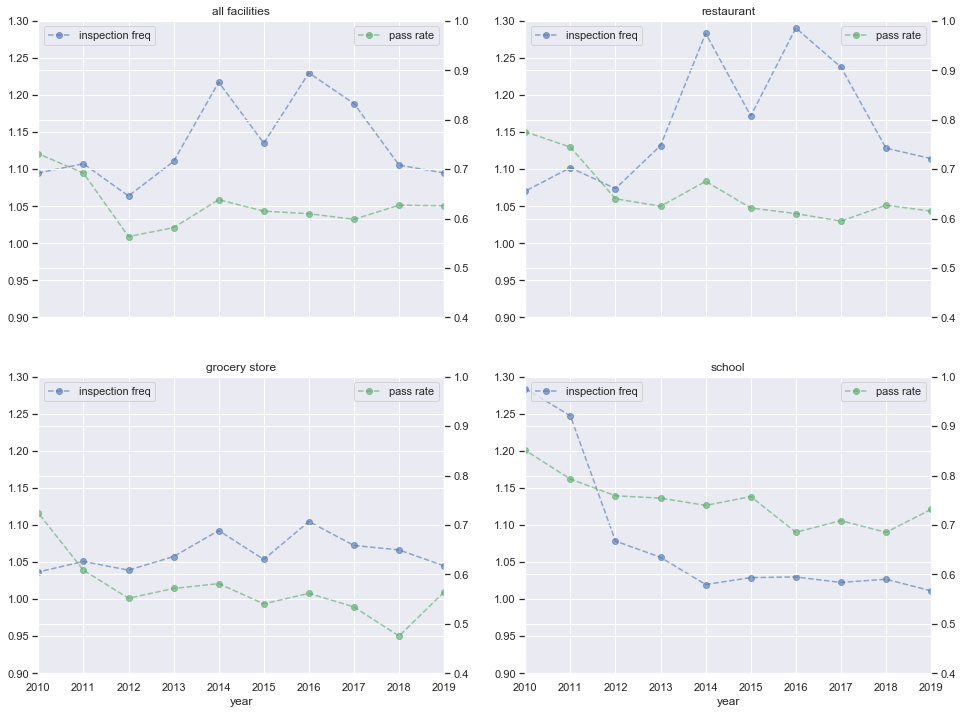

In [530]:
fac_eg = ['all facilities', 'restaurant', 'grocery store', 'school']
risks = ['Risk 1 (High)', 'Risk 2 (Medium)', 'Risk 3 (Low)']

ins_pass_rate = []
for i in year:
    year_i = df_canv[df_canv['year'] == i]
    for j in fac_eg:
        if j == 'all facilities':
            ins_pass_rate.append([i, j, year_i.shape[0], \
                                           year_i.shape[0] / len(year_i['License #'].unique()), \
                                           year_i[(year_i['results'] == 'Pass') | (year_i['results'] == 'Pass w/ Conditions')].shape[0] / year_i.shape[0]])
        else:
            fac_j = year_i[year_i['facility type'] == j]
            ins_pass_rate.append([i, j, fac_j.shape[0], \
                                           fac_j.shape[0] / len(fac_j['License #'].unique()), \
                                           fac_j[(fac_j['results'] == 'Pass') | (fac_j['results'] == 'Pass w/ Conditions')].shape[0] / fac_j.shape[0]])

ins_pass_rate = pd.DataFrame(ins_pass_rate)
ins_pass_rate.columns = ['year', 'facility type', 'inspection #', 'inspection freq', 'pass rate']
ins_pass_rate = ins_pass_rate.set_index(['year'])


fig = plt.figure(figsize = (16, 12))
style = ['bo--', 'go--']
l = ['inspection freq', 'pass rate']

for i, j in enumerate(fac_eg):
    fig_num = 221 + i
    ax = fig.add_subplot(fig_num)
    
    ins_pass_rate[ins_pass_rate['facility type'] == j][l[0]].plot(ax = ax, style = style[0], alpha = 0.6, label = l[0])
    plt.ylim(0.9, 1.3)
    plt.legend(loc = 2)

    ax2 = ax.twinx()
    ins_pass_rate[ins_pass_rate['facility type'] == j][l[1]].plot(ax = ax2, style = style[1], alpha = 0.6, label = l[1])
    plt.ylim(0.4, 1)
    plt.legend(loc = 1)
    
    plt.title(j)

# Violation-result analysis

<u> **Basic result analysis** </u>

In [101]:
df_ins_result = DF.copy()
df_ins_result.columns

Index(['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Facility Type',
       'Risk', 'Address', 'City', 'State', 'Zip', 'Inspection Date',
       'Inspection Type', 'Results', 'Violations', 'Latitude', 'Longitude',
       'facility type', 'year', 'month', 'day', 'inspection type', 'results'],
      dtype='object')

In [71]:
df_ins_result = df_ins_result.groupby('inspection type')['results']
df_ins_result = pd.DataFrame(df_ins_result.apply(lambda x:x.value_counts())).unstack()['results'].fillna(0)
df_ins_result['total number'] = df_ins_result.values.sum(axis = 1)

for i in df_ins_result.columns:
    if i!= 'total number':
        df_ins_result[i] = df_ins_result[i]/df_ins_result['total number']

In [39]:
df_ins_result.columns

Index(['Fail', 'License Suspended', 'No Entry', 'Not Ready', 'Pass',
       'Pass w/ Conditions', 'total number'],
      dtype='object')

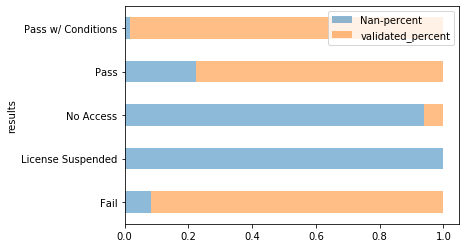

In [57]:

df_NaVio = df_vio[df_vio['Violations'].isna()]
df_NanPerc = pd.DataFrame(df_NaVio.groupby(['results'])['Inspection ID'].count())
df_NanPerc.columns = ['NaN values']

df_temp = pd.DataFrame(df_vio.drop(index = df_NaVio.index).groupby(['results'])['Inspection ID'].count())
df_temp.columns = ['Values']
df_NanPerc = df_NanPerc.join(df_temp).fillna(0)
df_NanPerc['Nan-percent'] = df_NanPerc['NaN values']/(df_NanPerc['Values']+df_NanPerc['NaN values'])
df_NanPerc['validated_percent'] = 1-df_NanPerc['Nan-percent']
df_NanPerc[['Nan-percent','validated_percent']].plot.barh(stacked=True, alpha=0.5)

In [58]:
df_NanPerc

,NaN values,Values,Nan-percent,validated_percent
results,,,,
Fail,3085,34650,0.081754,0.918246
License Suspended,16748,29,0.998271,0.001729
No Access,7576,483,0.940067,0.059933
Pass,23575,81548,0.224261,0.775739
Pass w/ Conditions,451,26519,0.016722,0.983278


We noticed that the `Nan` values distributions over differents are quite different. <br>
Except the situation of missing values,`Nan` values' proportion are higher in `Pass`,`License Suspended`,`No Entry` and `Not ready` we considering that there are different reasons each ithem that occur this phenomena: <br>
- `Pass` We consider that this indicate that there is no violations were found during the inspection.
- `License Suspended` From the dataset discription,we know that suspending license only occurs when critial violations found or violation not been corrected before re-inspection.<br> We think that reason why this category has such `Nan` value proportion is that when the most inspector didn't record the violatons once they decided to suspend the license of the ficility.
- `Not Ready` and `No Entry` have similar sitiation that happened in `License Suspended`
<br> 


Seprate by 01.07.2018,which day they changed the violation code

In [102]:
def final_all_labels(vio_vec):
    label = []
    if vio_vec[0:14].sum()> 0:
        label.append('critical')
    if vio_vec[14:29].sum()>0:
        label.append('serious')
    if vio_vec[29:46].sum()>0:
        label.append('minor')
    return label
df_vio1['label'] = df_vio1['Violation_vector'].apply(lambda x:final_all_labels(x)) 


<u> **Description of Inspection** </u>


According to the website about the detail of Chicago food inspection description:<u><a href="https://webapps1.chicago.gov/healthinspection/Code_Violations.jsp?fbclid=IwAR0NMn4WEEQqHelYLRwh-z1czAhMinI0ufWgbK33bfjxA6B7sn0qlCTiraQ#1crit">link</a></u>.<br>
We can see that the results are related to the violations and the inspection type of this inspection.In this document, there is detailed description of different violations.

- Critical vioilation: From the description,Onece a critical violation found in fiacity,if it can not be corrected immediately,it will recieve a `License suspended`.
- Serious violation: Serious violationo found without correction immediately won't casuse `License suspended`, only cause `Fail` and a re inspection.But if serious violation found in re inspection will cause a `License sunspended`.
- Minor violarion: within Minor violations can still have a `Pass` result.

- Exception: In License related inspections, any violation including 'Minor' will cause a `Fail`


In the following part, We want to have a view of the Violation-Results relationship:

In [103]:
df_vio1['label']
df_vio_result_1= df_vio1.explode('label').dropna(subset = ['label'])
df_vio_result_1 = df_vio_result_1.groupby(['label','results','inspection type']).size().unstack()

For `3 violations` we have its inspection type and results:

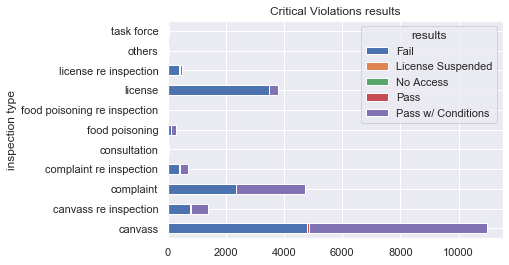

In [107]:
df_vio_result_1.loc['critical'].T.fillna(0).plot.barh(stacked = True,title = "Critical Violations results")


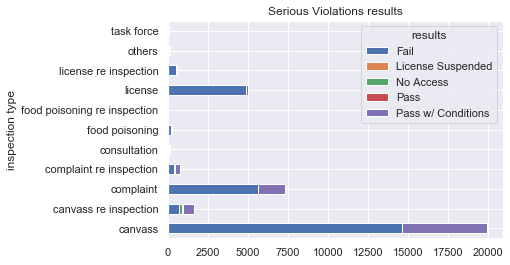

In [109]:
df_vio_result_1.loc['serious'].T.fillna(0).plot.barh(stacked = True,title = "Serious Violations results")

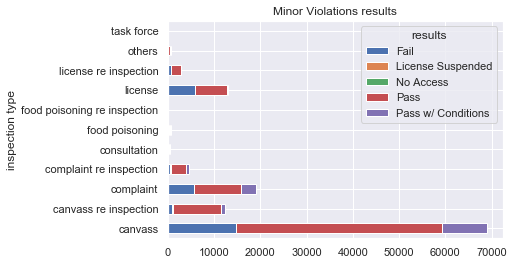

In [108]:
df_vio_result_1.loc['minor'].T.fillna(0).plot.barh(stacked = True,title = "Minor Violations results")

We absored that in real inspection, they didn't follow exactly as described, for example, In the description, `Fail` result won't appear in the inspections that `Critical viol` was found.<br>
As for different kinds of inspections, it can be easily noticed that their results distributions are not the same as well.

### Violation Changings

From the resource of this dataset:<u><a href="https://data.cityofchicago.org/Health-Human-Services/Food-Inspections/4ijn-s7e5">Chicago food inspection</a></u>.<br>We know that the inspection procedures using new form to record the inspection data as described here:<u><a href="http://bit.ly/2yWd2JB">new data form</a></u><br>
The main Changes are about the Violations, including the categories and responding Violation numbers. In the new dataset, the types of violations are not 45, instead of 63.<br>
Corresponding name changes of violations' categories are as follows:
- ` Minor Violations`  to `Core (C) Violation`
- `Serious Violations` to `Priority Foundation (PF) Violation`
- `Critical Violations` to `Priority (P) Violation`<br>
From the description,it can be seen that there is a corresponding relationship between new and previous violation categories.

For these changed violations, there is no description about the which catagory that new violations should belong to.In this case, we tried to use clustering to group violations depends on their pass rate of 4 most high-frequency inspection types.

Since previous inspection violation have the truth category, We did k-Means clustering for the violations before 1/7/2018 to check the the performance

In [72]:
#extract the major inspection type and results
major_ins = df_ins_result['total number'].sort_values(ascending= False ).head(4).index
major_resu =df_vio1.groupby('results').size().sort_values(ascending= False ).head(3).index

In [73]:
df_vio1_e = df_vio1.explode('Violation_num')#.dropna(subset = 'Violation_num')
df_vio1_e = df_vio1_e.dropna(subset = ['Violation_num'])
df_vio_ins1=pd.DataFrame(df_vio1_e[df_vio1_e['inspection type'].isin(major_ins)].groupby(['Violation_num','inspection type','results']).size())

In [74]:
df_vio2_e = df_vio2.explode('Violation_num')#.dropna(subset = 'Violation_num')
df_vio2_e = df_vio2_e.dropna(subset = ['Violation_num'])
df_vio_ins2=pd.DataFrame(df_vio2_e[df_vio2_e['inspection type'].isin(major_ins)].groupby(['Violation_num','inspection type','results']).size())

In [75]:
#compute the different results' rate in different inspection type

df_vio_feature_1 = df_vio_ins1.unstack()[0].fillna(0)
for i in major_resu:
    df_vio_feature_1[i+'_rate'] = df_vio_feature_1.apply(lambda x:x[i]/x.values.sum(axis =0),axis = 1)
df_vio_feature_1 = df_vio_feature_1[['Pass w/ Conditions_rate','Fail_rate','Pass_rate']].unstack().fillna(0)

In [76]:
#compute the different results' rate in different inspection type
df_vio_feature_2 = df_vio_ins2.unstack()[0].fillna(0)
for i in major_resu:
    df_vio_feature_2[i+'_rate'] = df_vio_feature_2.apply(lambda x:x[i]/x.values.sum(axis =0),axis = 1)
df_vio_feature_2 = df_vio_feature_2[['Pass w/ Conditions_rate','Fail_rate','Pass_rate']].unstack().fillna(0)

In [77]:
X1 = df_vio_feature_1.values
y=df_vio_feature_1.index.map(lambda x:2 if x<= 14 else 0 if x>=30 else 1)

In [78]:
X2 = df_vio_feature_2.values

In [82]:
pca = PCA(n_components=3)
pca1 = pca.fit_transform(X1)

In [83]:
# use PCA to reduce the dimension to do the visulization
pca = PCA(n_components=3)
pca2 = pca.fit_transform(X2)

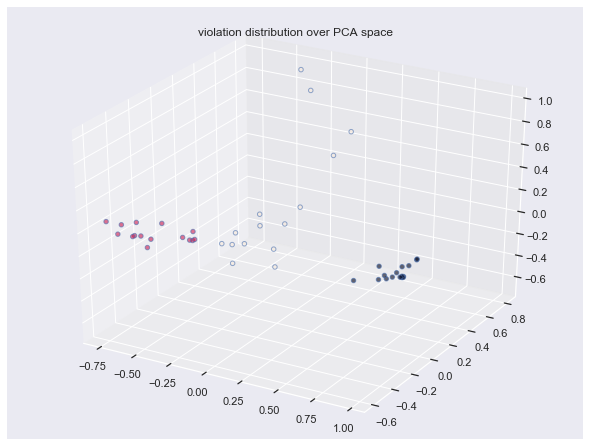

In [84]:
pca = PCA(n_components=3)
pca1 = pca.fit_transform(X1)
sns.set()

kmeans1 = KMeans(n_clusters=3, random_state=0).fit(X1)


fig = plt.figure(figsize=(8, 6))

ax = Axes3D(fig)
ax.scatter(pca1[:,0],pca1[:,1],pca1[:,2], c=kmeans1.labels_, alpha=0.6, edgecolors='b')
# ax.scatter(pca1[:,0],pca1[:,1],pca1[:,2], c=y, alpha=0.6, edgecolors='0')
# ax.set_xlabel('Residual Sugar')
# ax.set_ylabel('Fixed Acidity')
# ax.set_zlabel('Alcohol')
ax.set_title('violation distribution over PCA space')


plt.show()


This 3D space is the space after the applying PCA on orignal input data

In [85]:
df_vio_feature_1['True']=y
df_vio_feature_1['predict'] = kmeans1.labels_

In [88]:
sklearn.metrics.f1_score(df_vio_feature_1['True'].values,df_vio_feature_1['predict'].values,average = 'macro')

0.7975618251480321

For the violations before 1/7/2018, F1_score is 0.79. And the distance of clustered group can be seen clearly as well.So we did the clustering for the new violation as well.

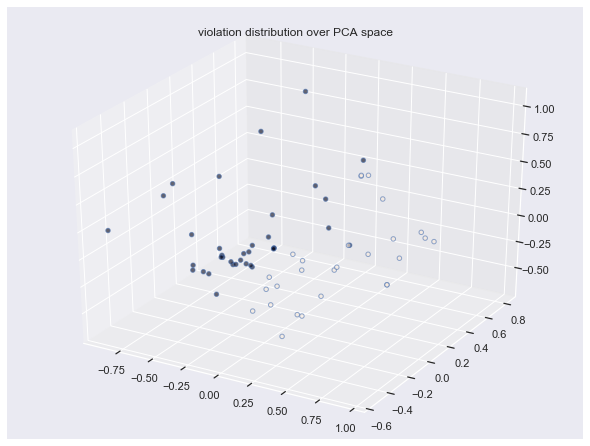

In [89]:
pca = PCA(n_components=3)
pca2 = pca.fit_transform(X2)
sns.set()
# Use KMeans clustering method
# X = np.array(merged[["%passed", "%failed", "%cond"]])
kmeans2 = KMeans(n_clusters=2, random_state=0).fit(X2)


fig = plt.figure(figsize=(8, 6))

ax = Axes3D(fig)
ax.scatter(pca2[:,0],pca2[:,1],pca2[:,2], c=kmeans2.labels_, alpha=0.6, edgecolors='b')
# ax.scatter(pca1[:,0],pca1[:,1],pca1[:,2], c=y, alpha=0.6, edgecolors='0')
# ax.set_xlabel('Residual Sugar')
# ax.set_ylabel('Fixed Acidity')
ax.set_title('violation distribution over PCA space')

plt.show()


For the violations after 1/7/2018, The clustering result seems not as well as the one before 1/7/2018.

Different results' proportion of all the inspections:


In [90]:
df_result_time = DF[['Inspection ID','Inspection Date','results']]
df_result_time['year'] = df_result_time['Inspection Date'].apply(lambda x:x.year)
df_result_time['month'] = df_result_time['Inspection Date'].apply(lambda x:x.month)
df_result_time = pd.DataFrame(df_result_time.groupby(['year','month','results']).size())
df_result_time = df_result_time.unstack()[0].fillna(0)

D:\anaconda3\envs\ada\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

D:\anaconda3\envs\ada\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [99]:
for i in DF['results'].unique():
    df_result_time[i+'_rate'] = df_result_time.apply(lambda x:x[i]/x.values.sum(axis =0),axis = 1)
df_result_time = df_result_time.rename(columns={"Pass_rate": "pure_Pass_rate"})

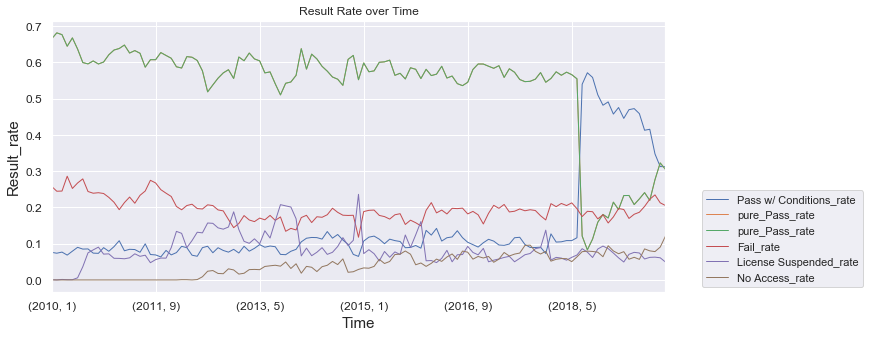

In [111]:
DF_yearisk = df_result_time[['Pass w/ Conditions_rate', 'pure_Pass_rate',
       'Fail_rate', 'License Suspended_rate', 'No Access_rate']]
fig = DF_yearisk.plot(figsize = (11,5), fontsize = 12, lw = 1)
fig.set_ylabel('Result_rate',fontsize = 15)
fig.set_xlabel('Time',fontsize = 15)
fig.set_title('Result Rate over Time')
plt.legend(bbox_to_anchor=(1.05, 0), loc=3)

From this graph,it can be seen that bafore 1/7/2018, although pass_rate and pass_w_condition rate fluctuate some times,the overall trend is stabilizing. <br>While after 1/7/2018,the ratio of these two inspection results to all results is reversed immediately.And we also can ovbserved that in the further time till newest inspection data,their ration tend to back to previous relationship.
We think this might be the reason why it's hard to use result_rate of certain violation to find out the violation catagory.<br>
Although we cannot use result_rate to infer the violations' severity, we notice this changing of inspection's violation category might help to improve the sanitary condition of facilities. Since the `pure_Pass_rate` has a huge falling after changing to new categories and then kept climbing, this might indicate that this new category put more violation not been used or considered serious before. And by increasing corresponding severity, it can force the facility to do better in this despised ascpect.The climbing of `pure_Pass_rate` proof of its effectiveness.